In [11]:
import os
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from aux import *
from visualize import *
from model import *

In [12]:
DATA_PATH = '../Data/'
class_ids = sorted([int(file_name.split('_')[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')])

# networks and affective matrices of all classes in wave 1
networks = {}
affective_matrices = {}
for class_id in class_ids:
    networks[class_id] = load_data(class_id, 1)
    affective_matrices[class_id] = pd.read_csv(DATA_PATH + str(class_id) + '_affective_w1.csv', \
                                               header = 0, index_col = 0)
    

In [13]:
# Game Structure
PAYOFF_FUNCTION = {('tell a secret', 'tell a secret'): (1, 1),
                   ('tell a secret', 'refrain'): (-1, 0),
                   ('refrain', 'tell a secret'): (0, -1),
                   ('refrain', 'refrain'): (0, 0)}

In [14]:
### Simulation by using logistic regression

In [15]:
# Set parameters
NUM_STEP = 6
bonus_for_friends = 0.6395
mode = 'logistic regression'

In [16]:
# Prepare for simulation
simulated_networks = {}

for class_id in class_ids:
    trust_network = networks[class_id]
    affective_matrix = affective_matrices[class_id]
    model = TrustModel(trust_network, affective_matrix, mode, bonus_m2m = 0, bonus_f2f = 0, bonus_for_friends = 0)
    simulated_networks[class_id] = model.run(NUM_STEP)

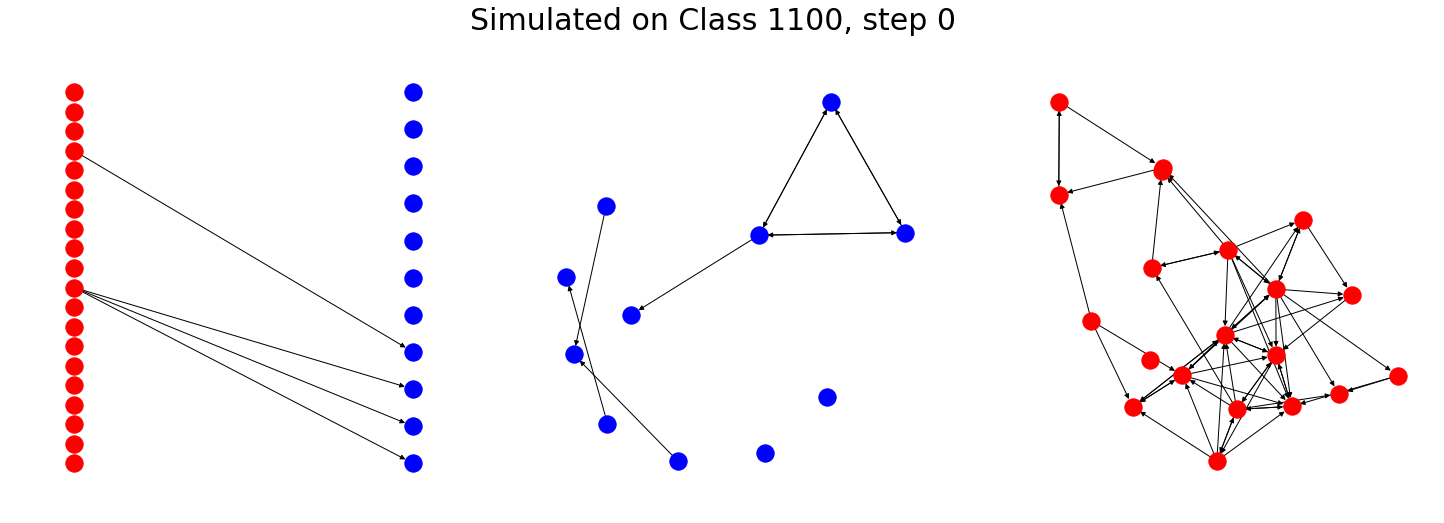

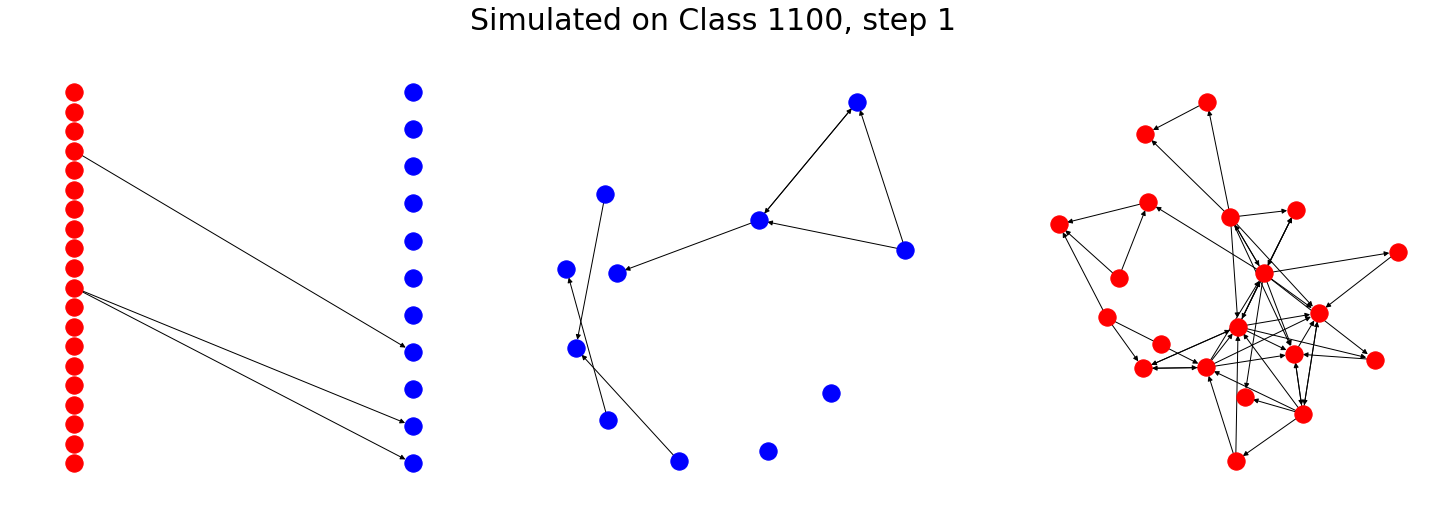

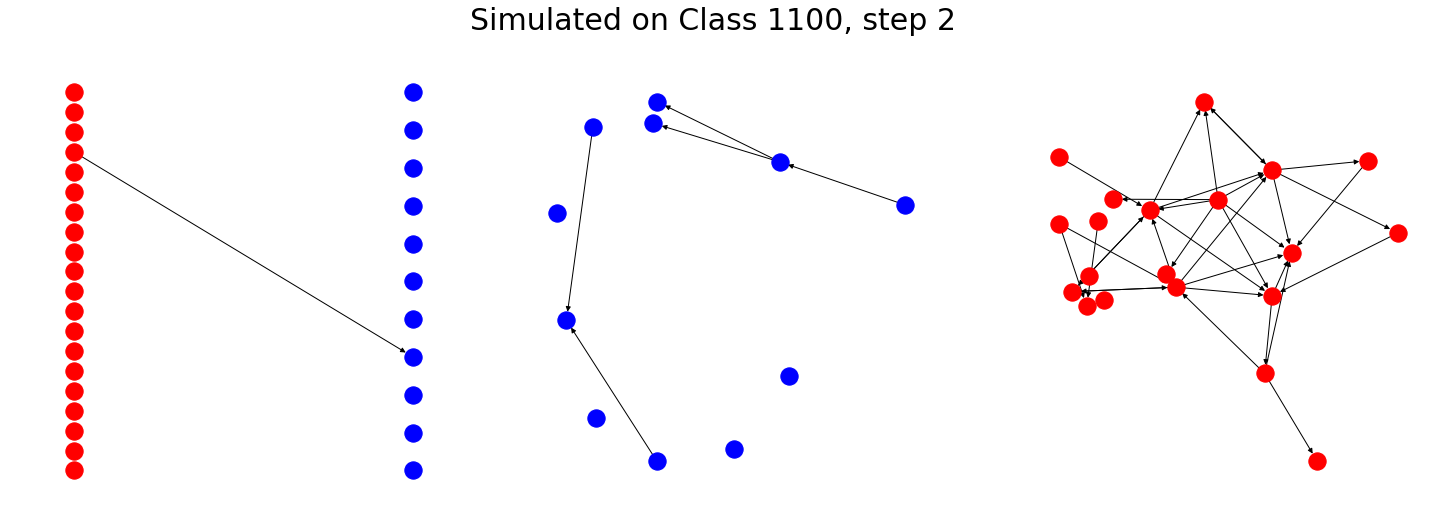

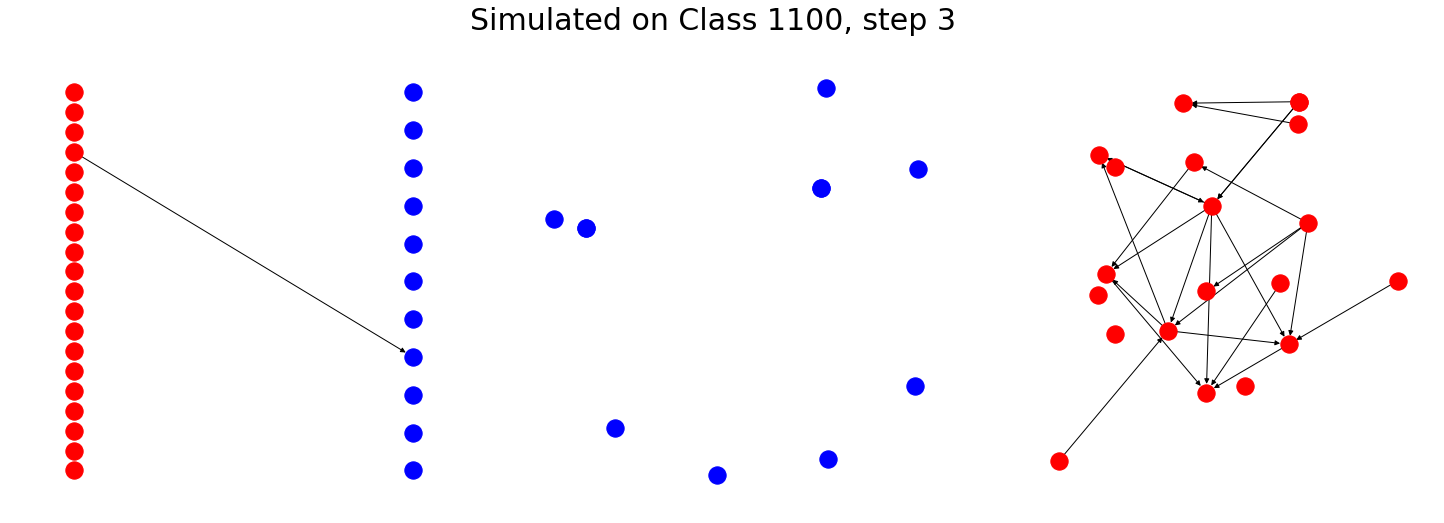

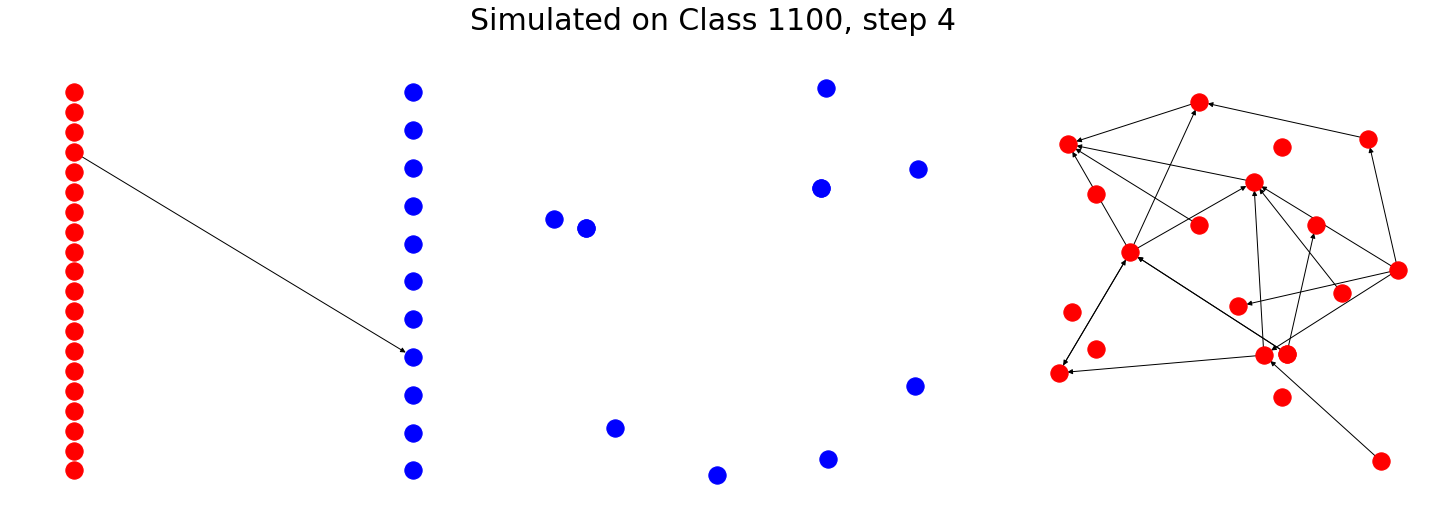

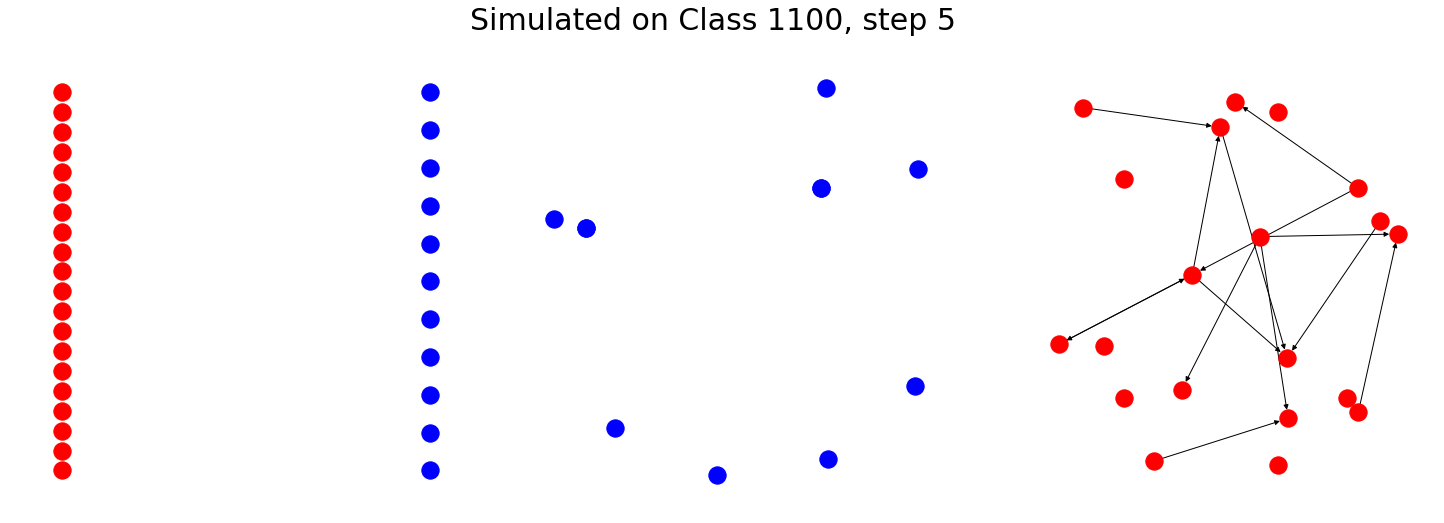

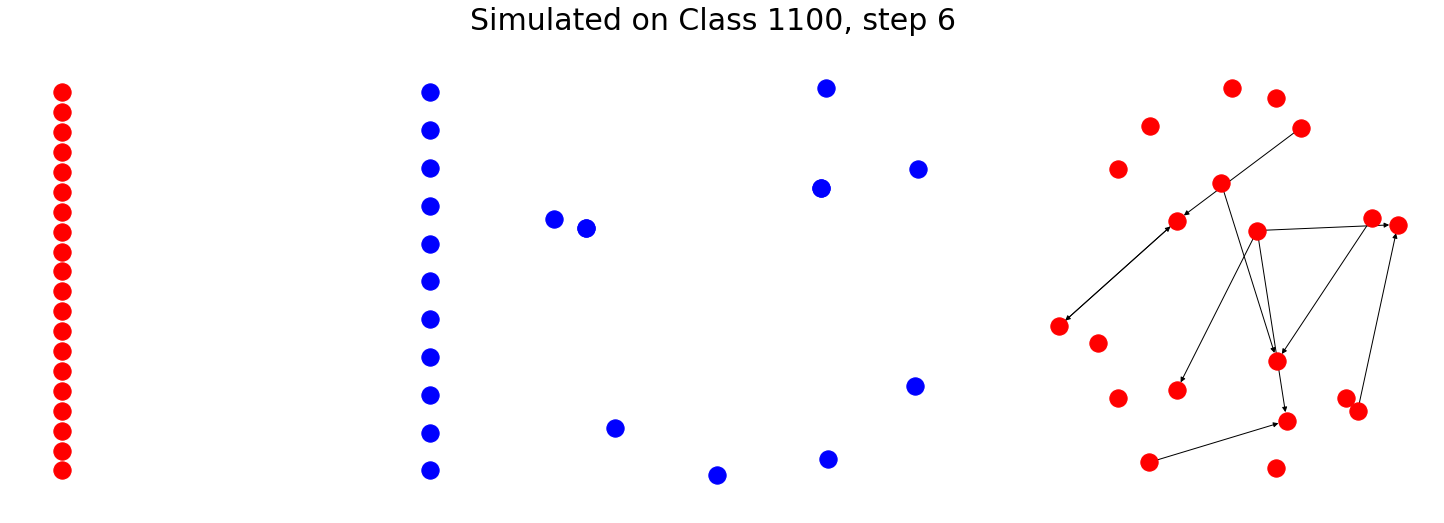

In [17]:
# Visualize a class in all steps
SELECTED_CLASS = 1100
for step in range(NUM_STEP + 1):
    visualize(simulated_networks[1100][step], SELECTED_CLASS, step)

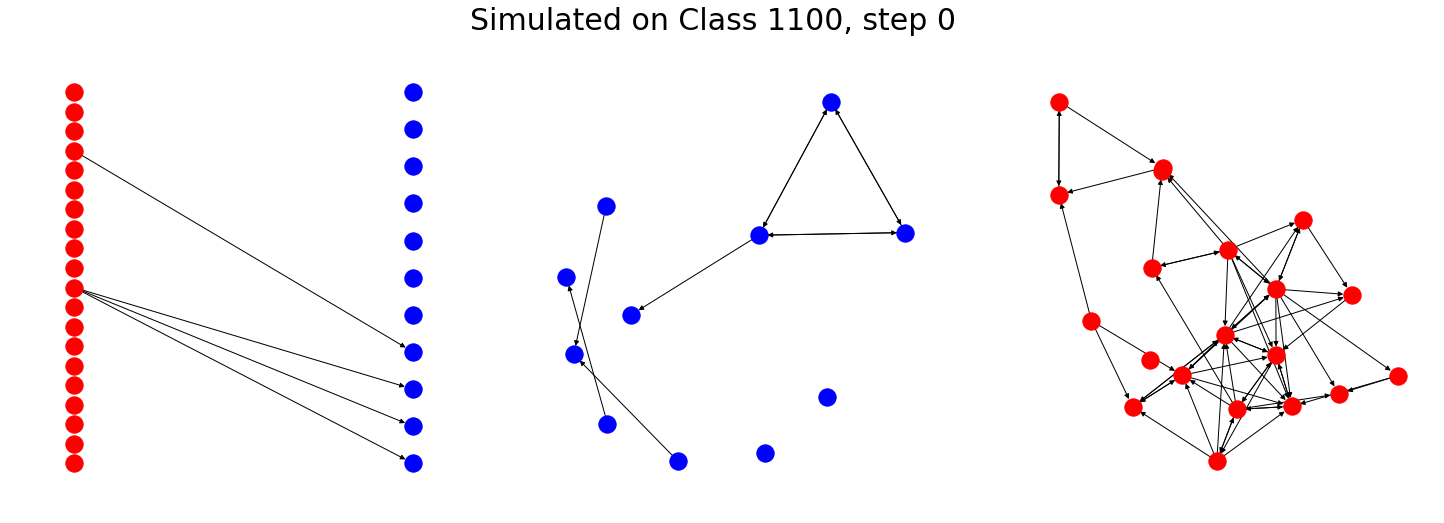

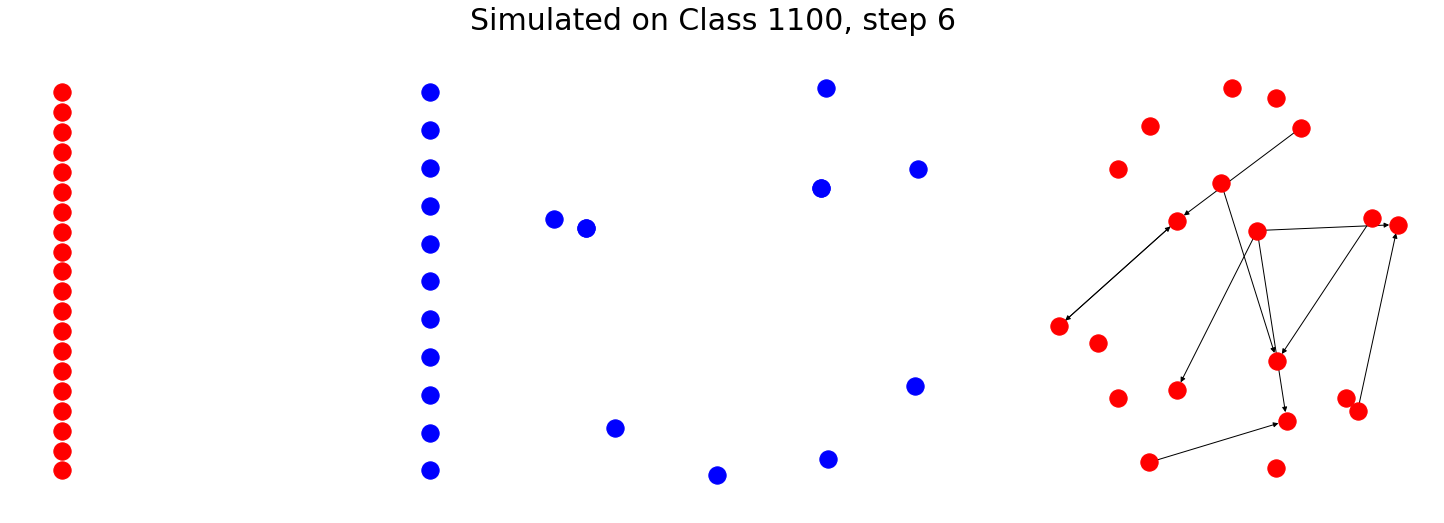

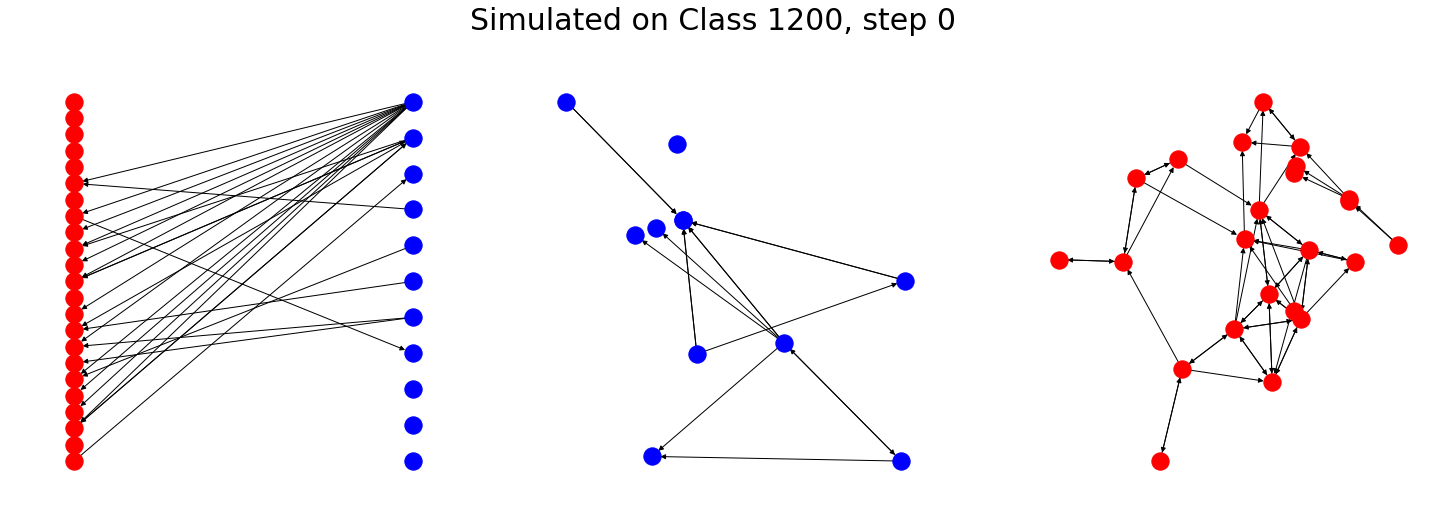

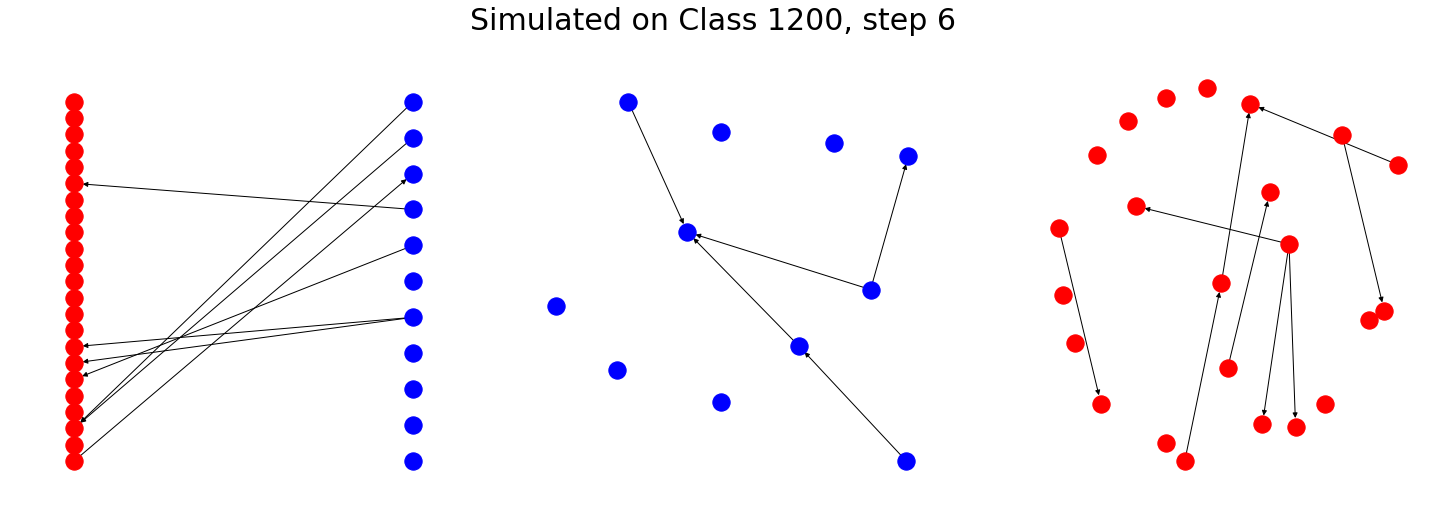

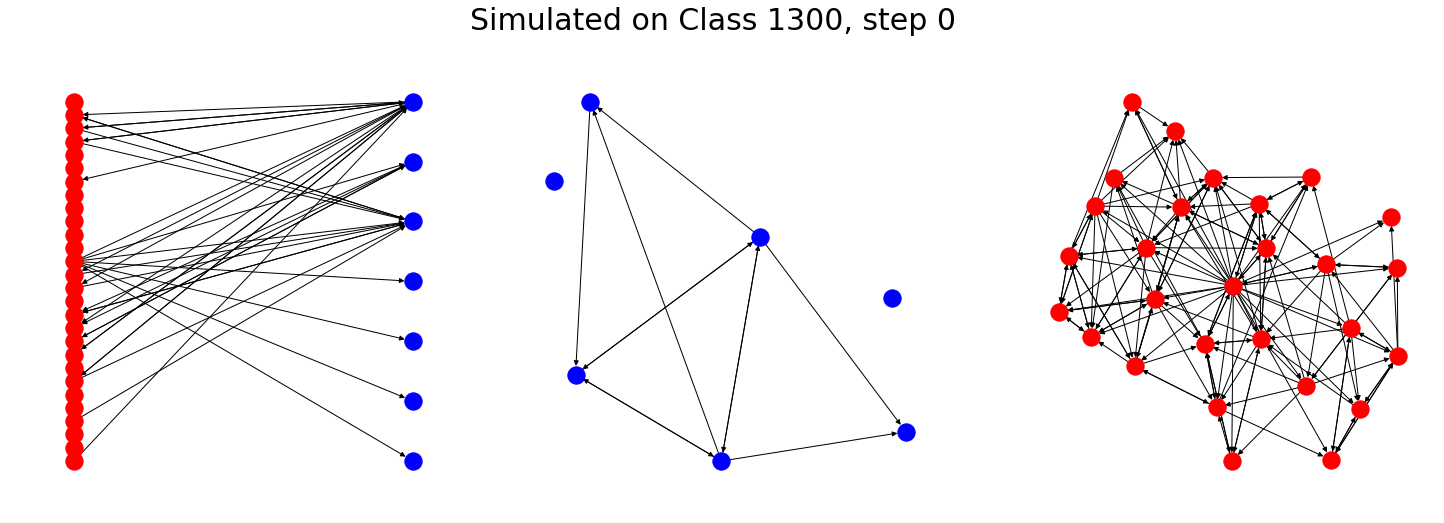

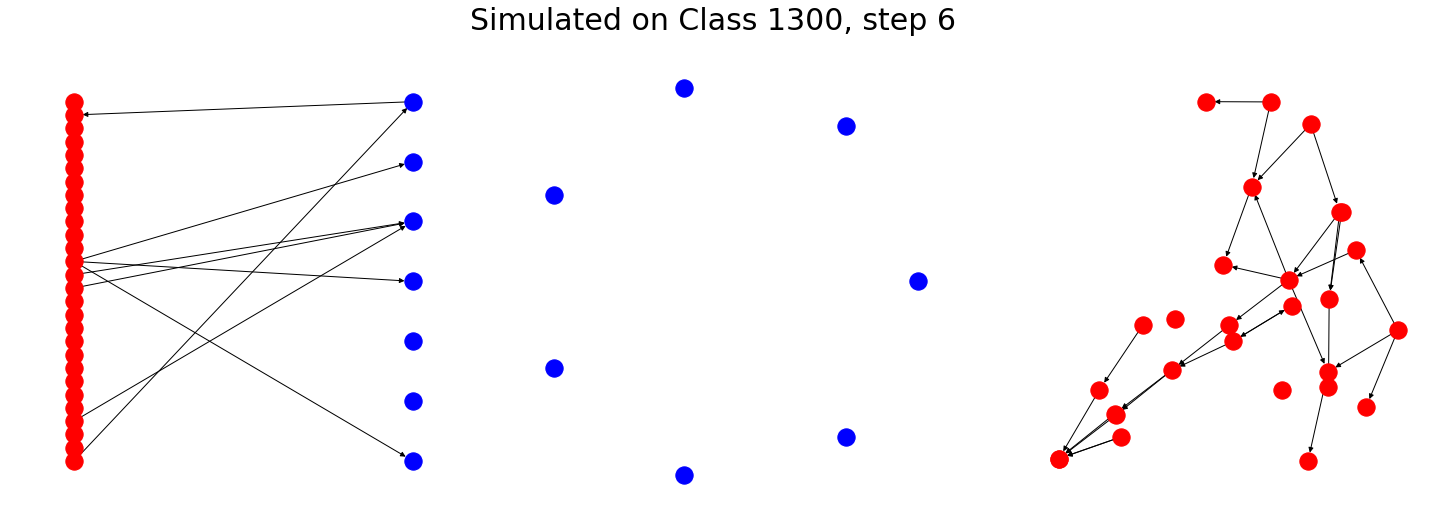

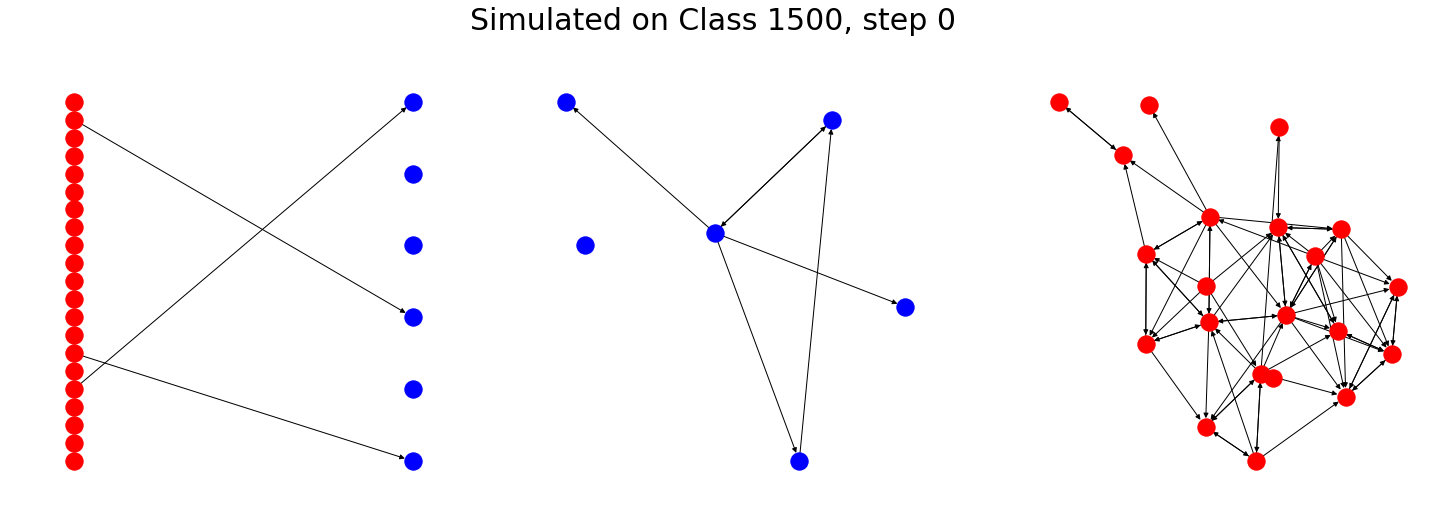

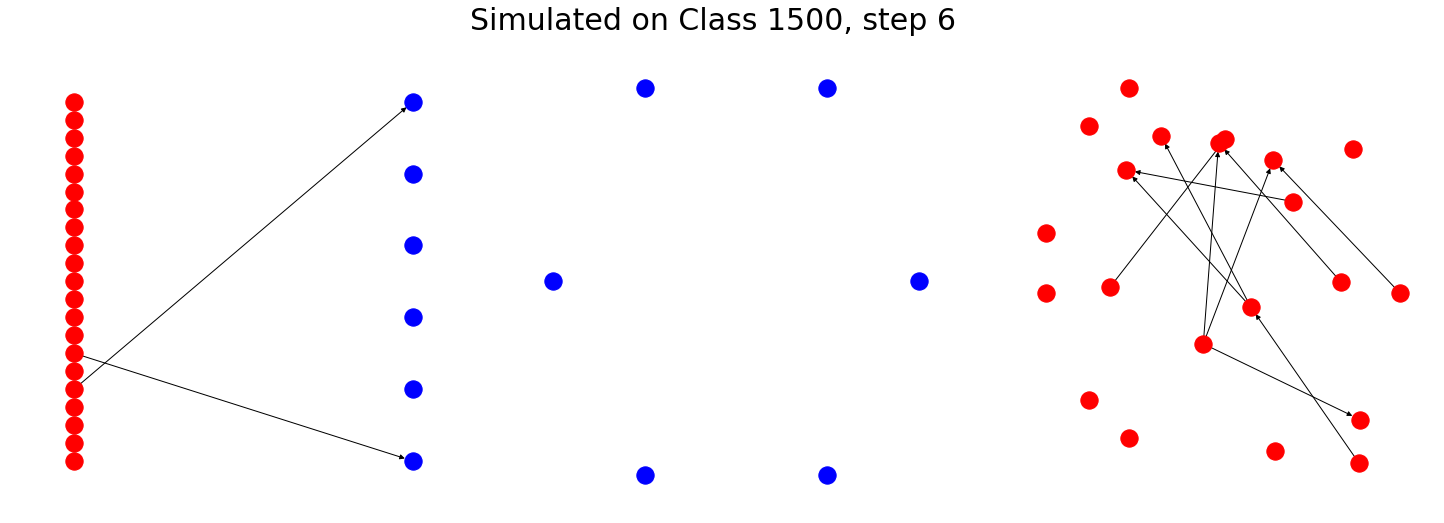

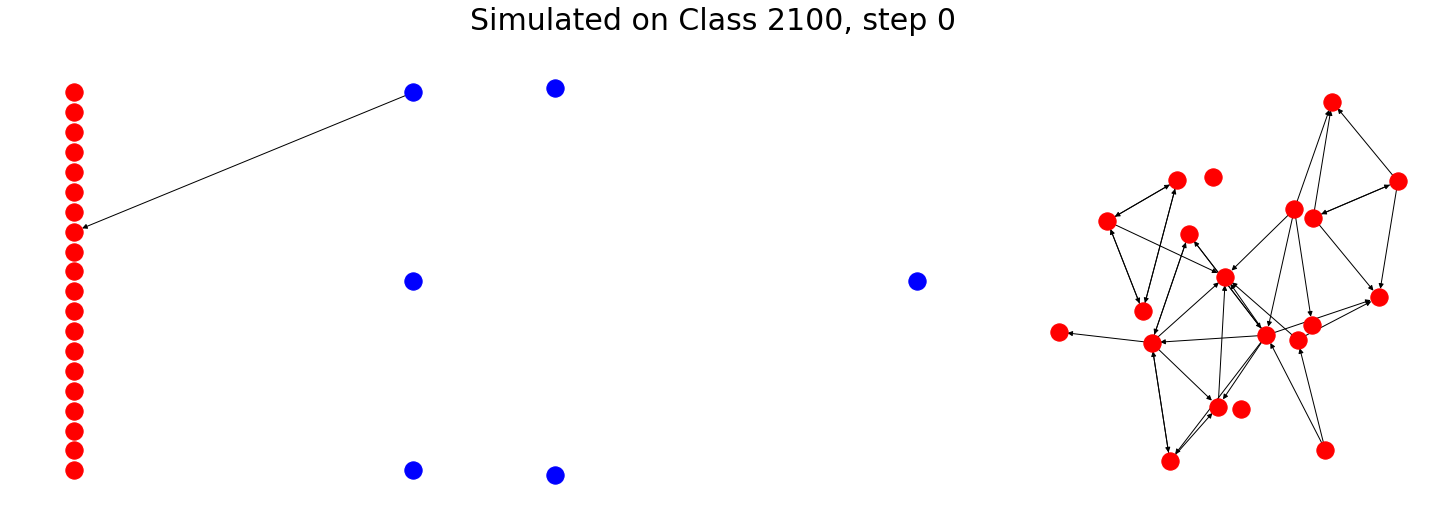

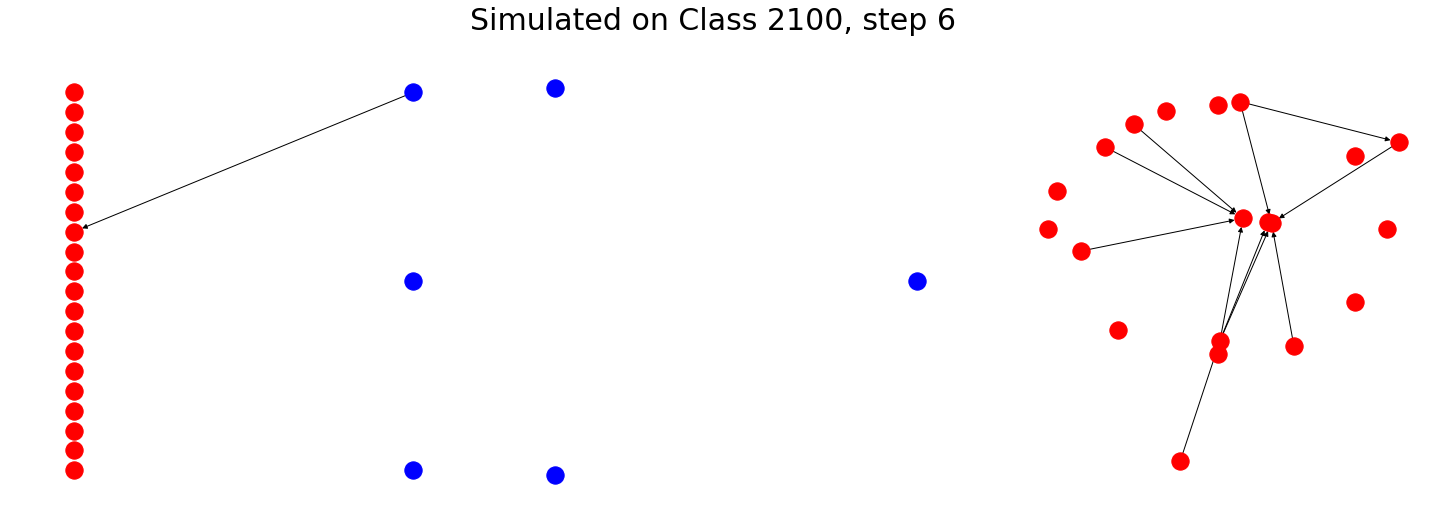

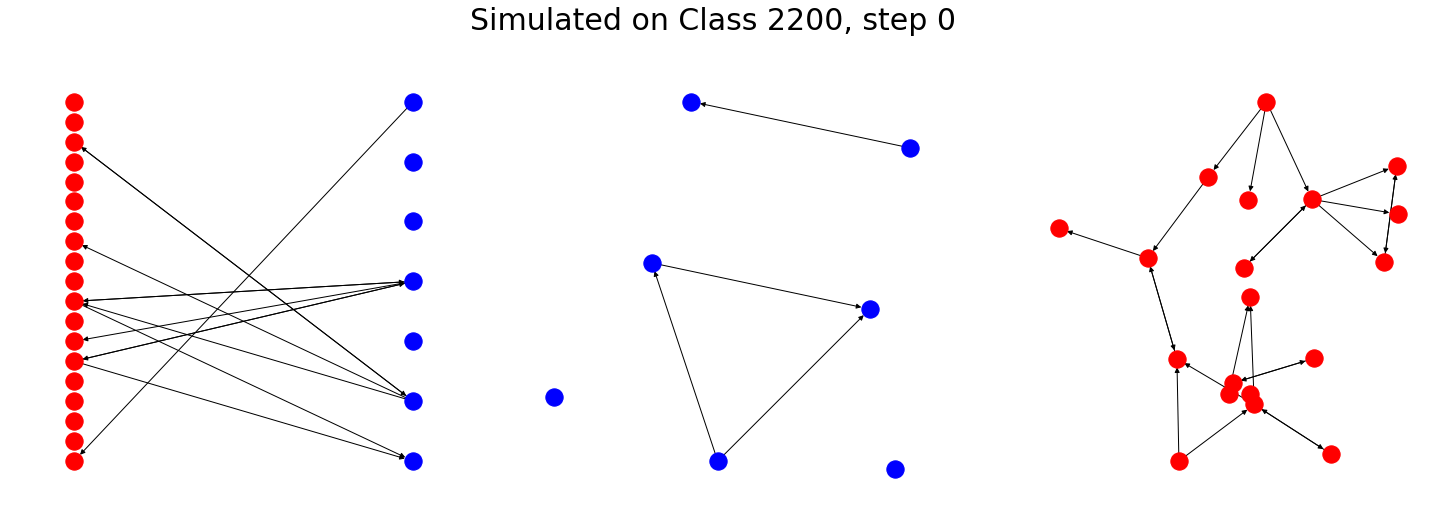

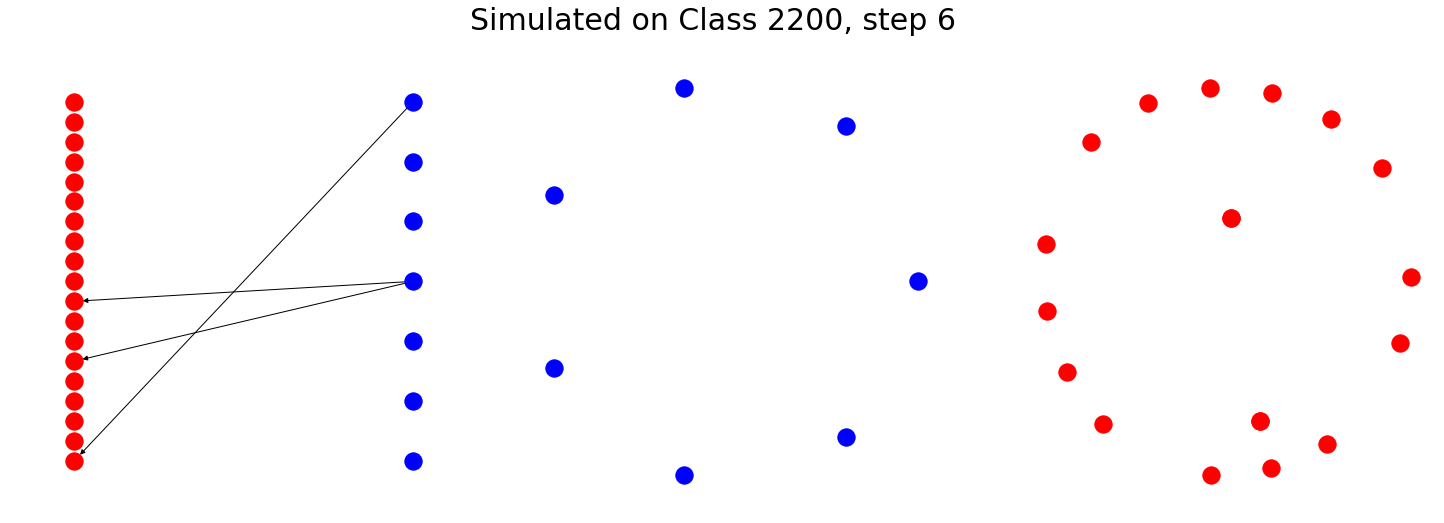

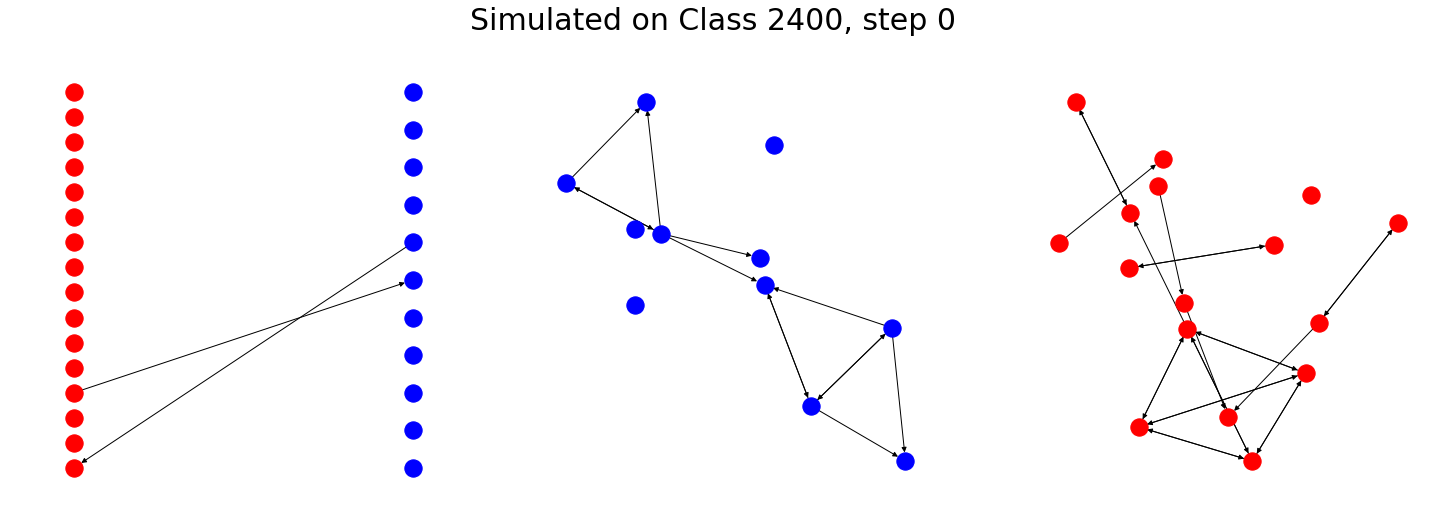

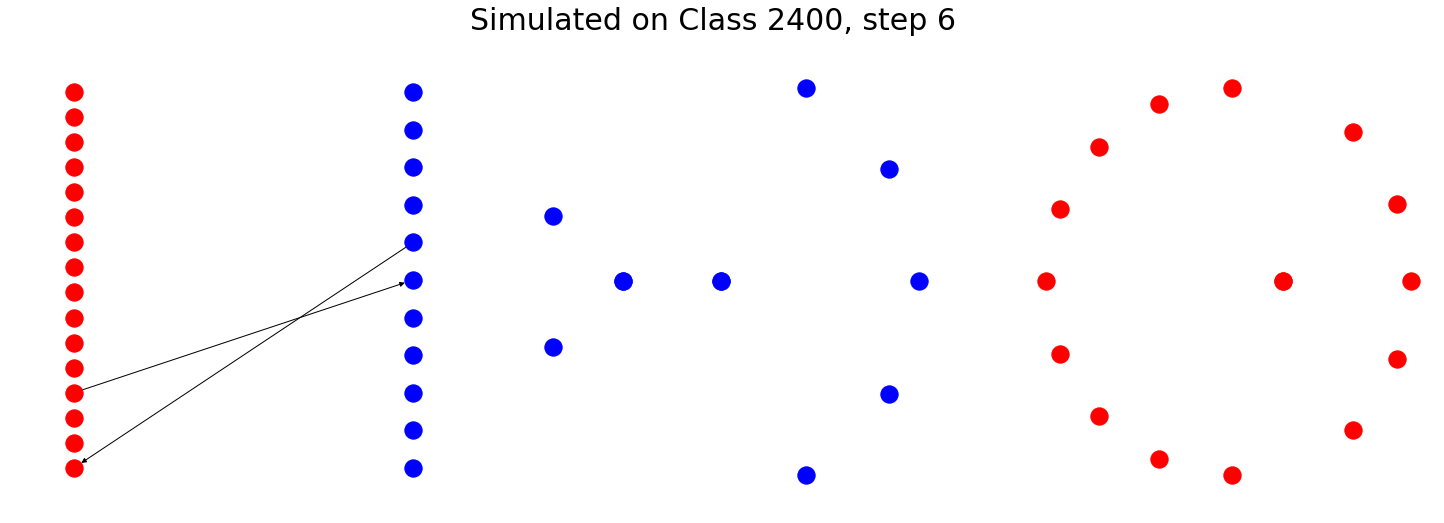

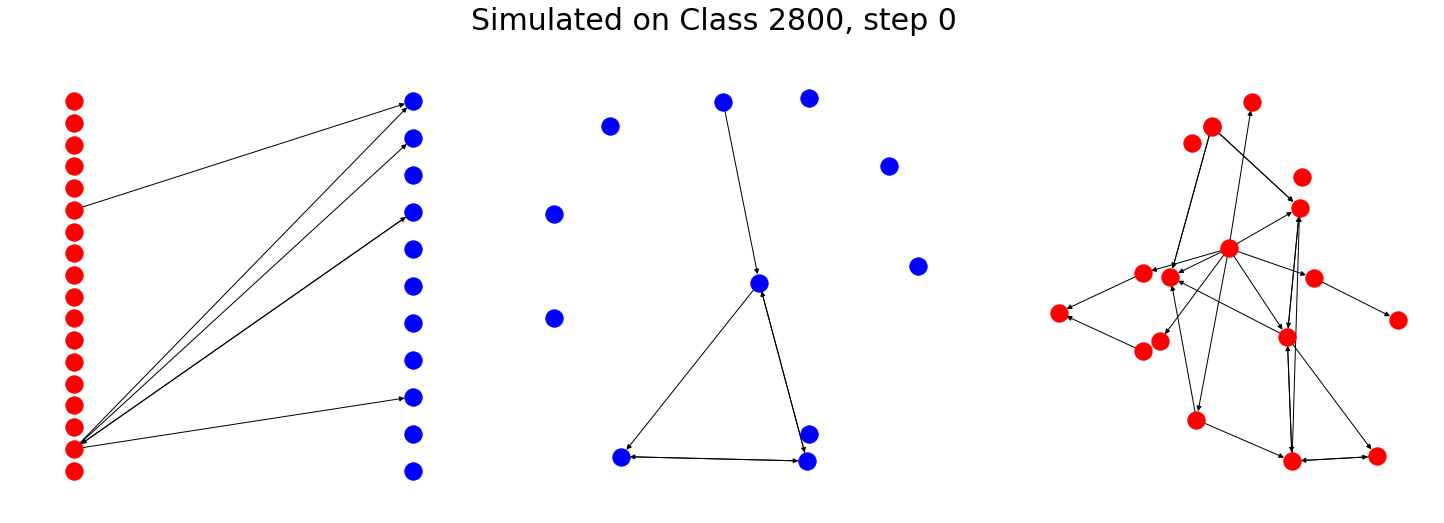

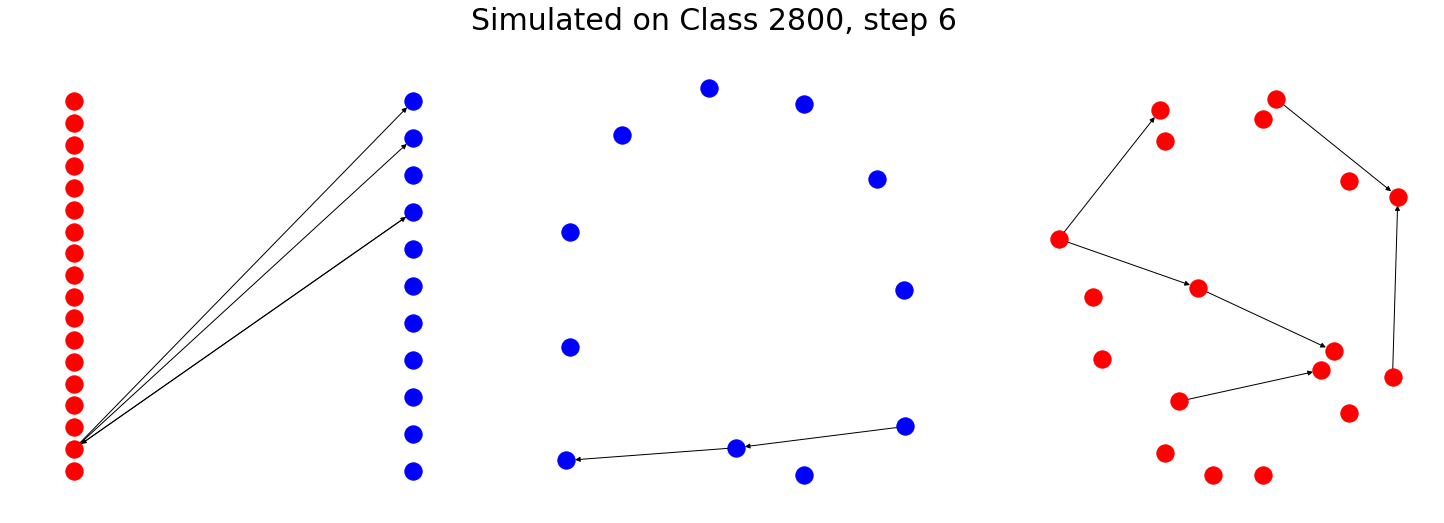

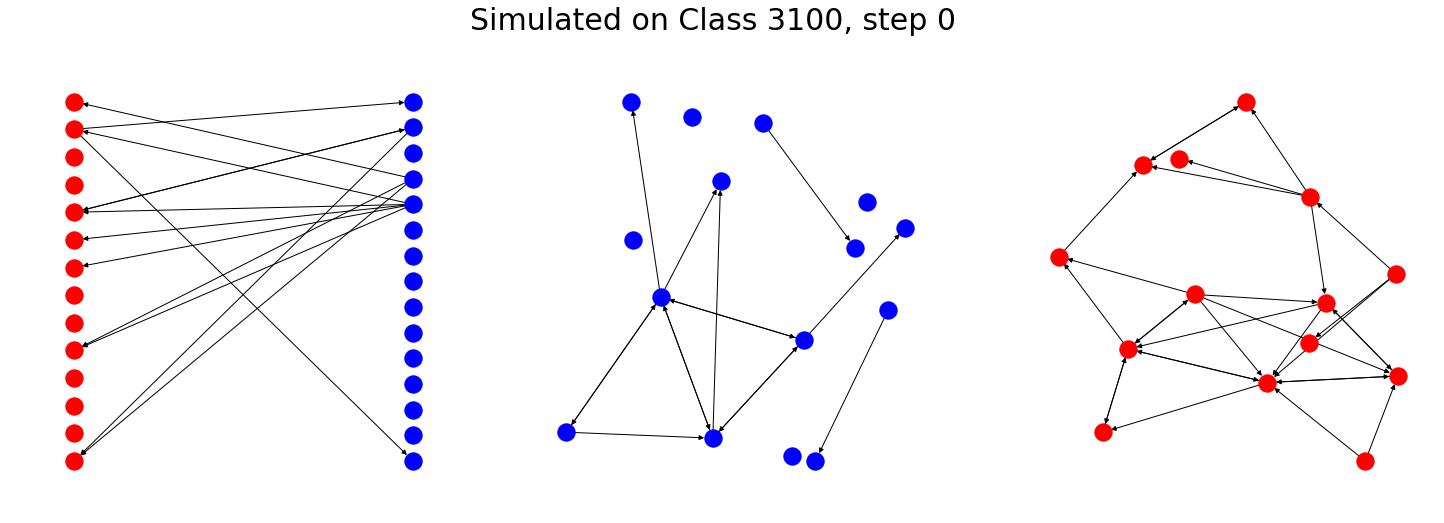

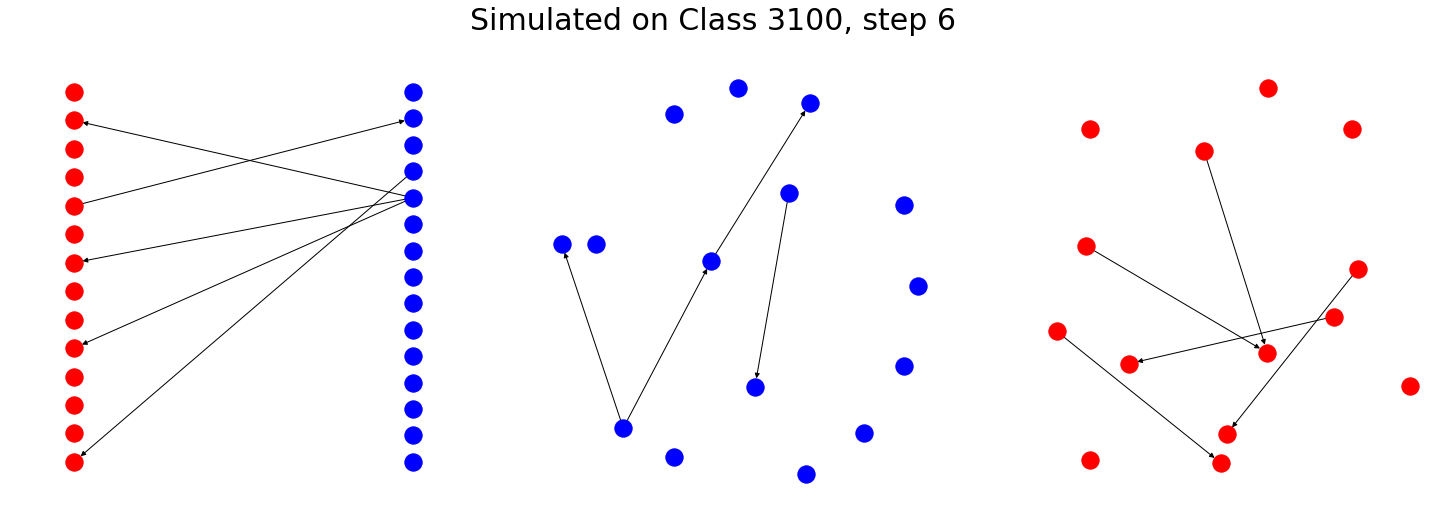

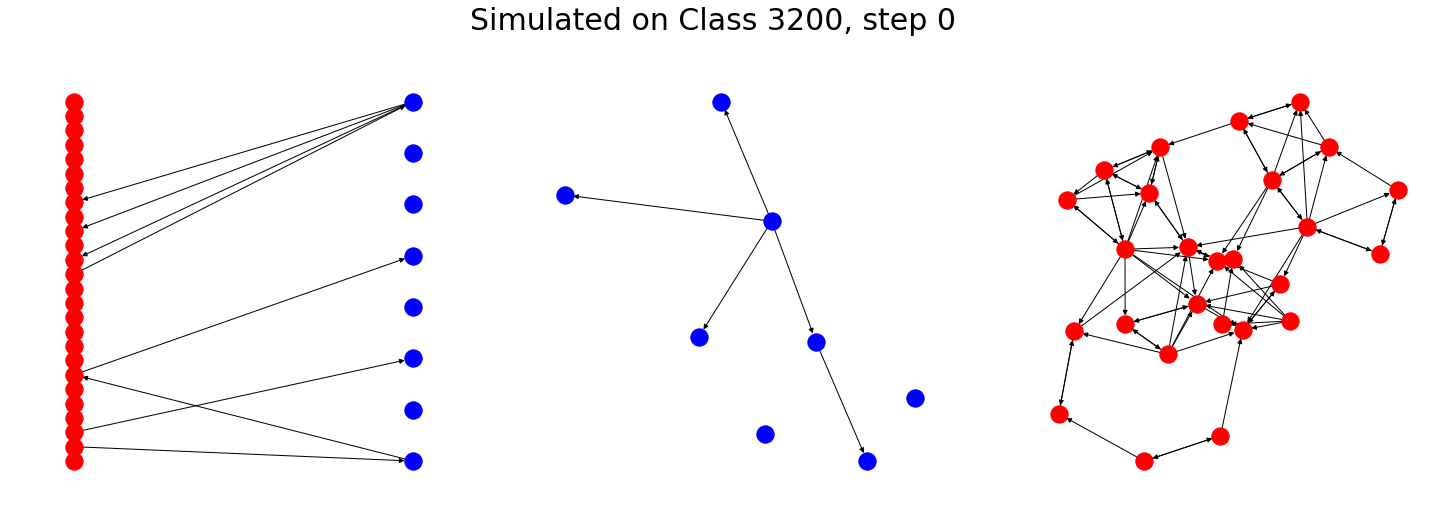

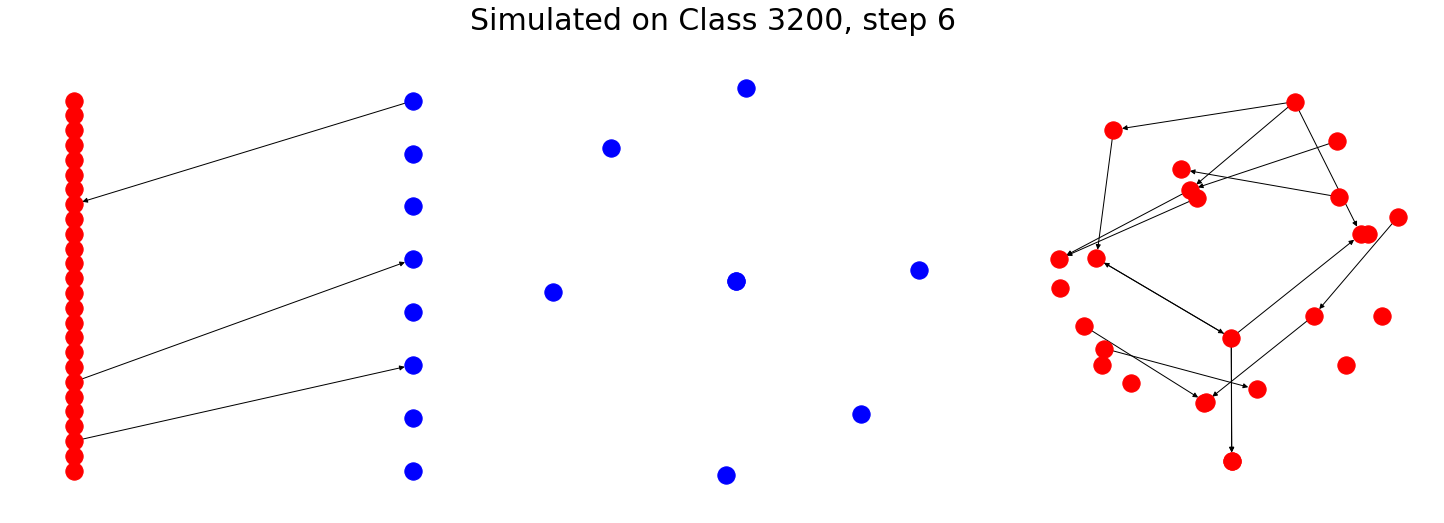

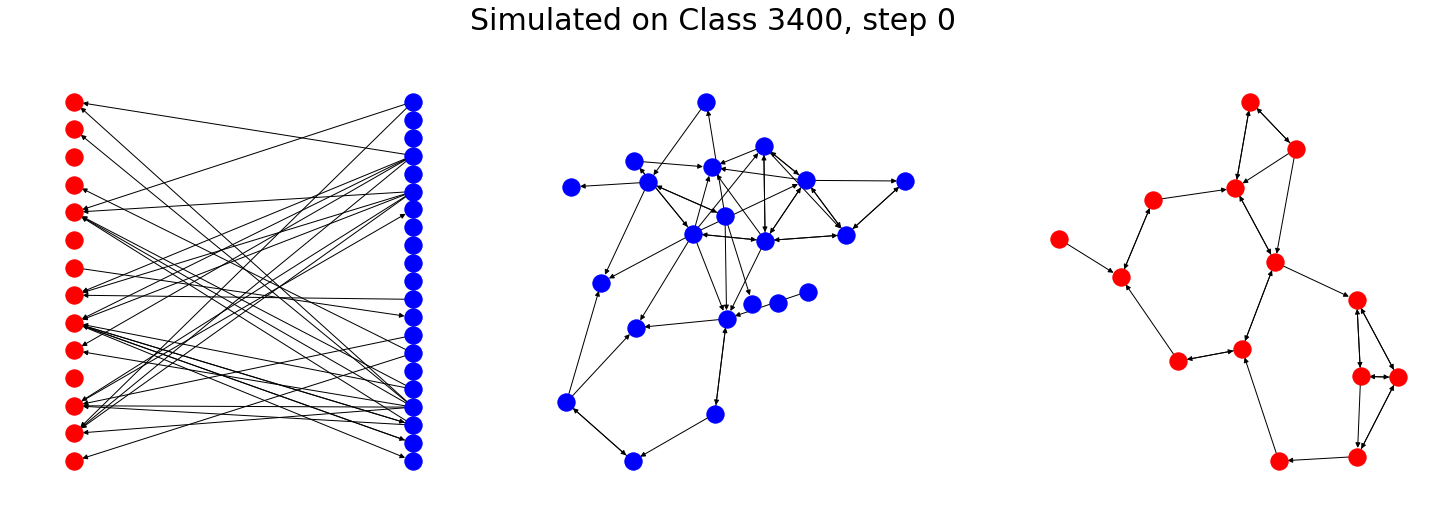

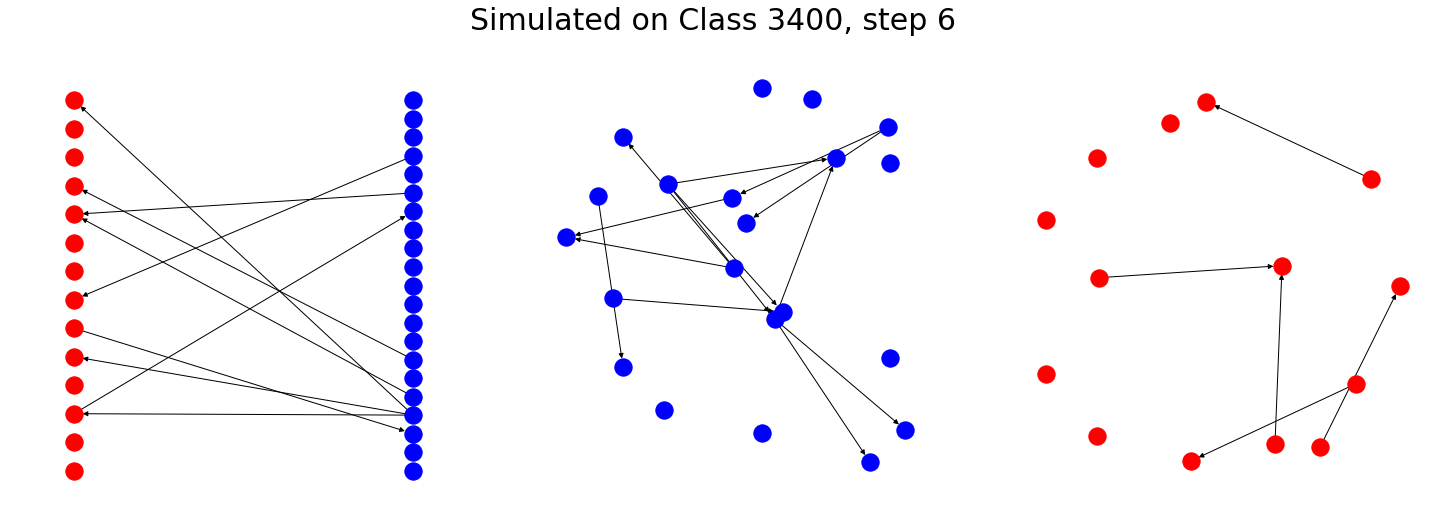

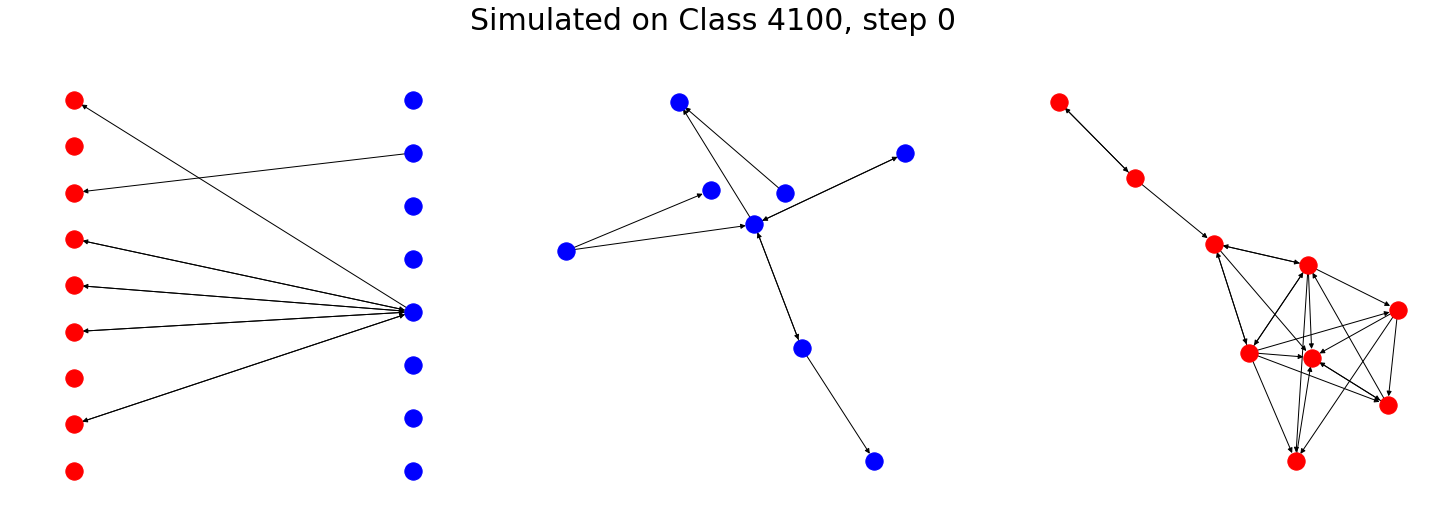

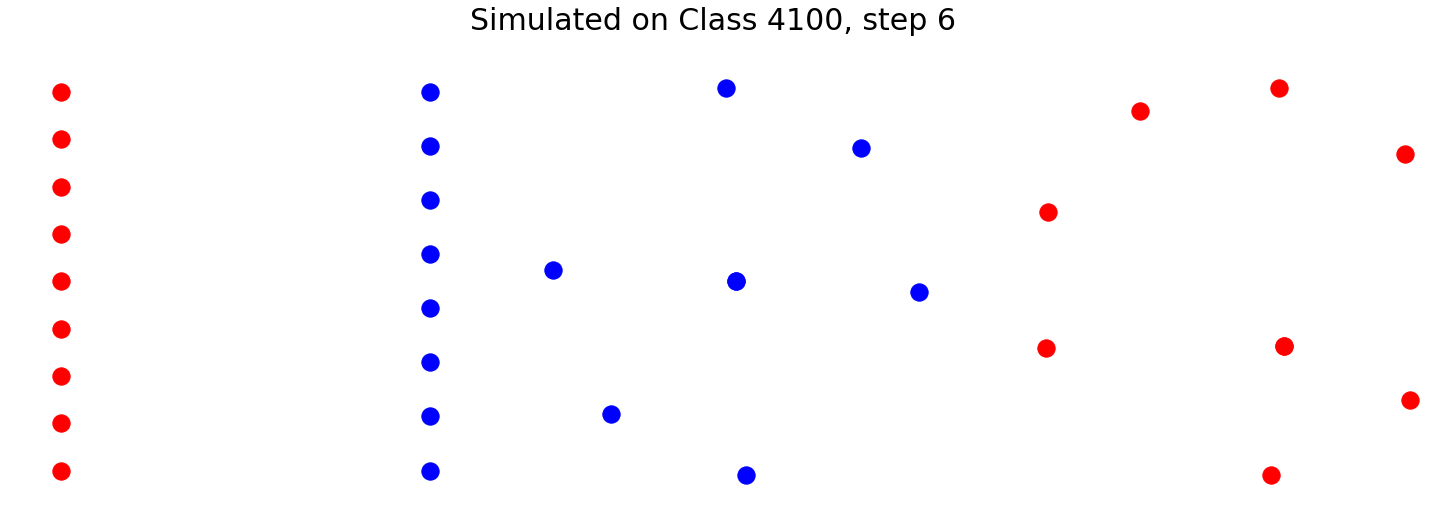

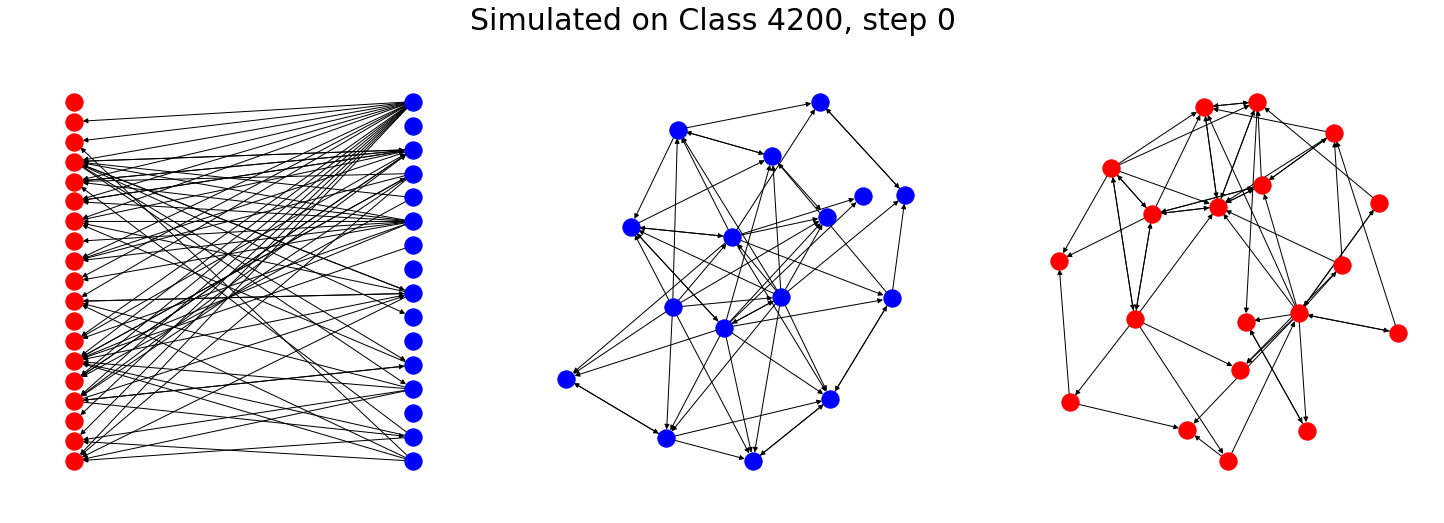

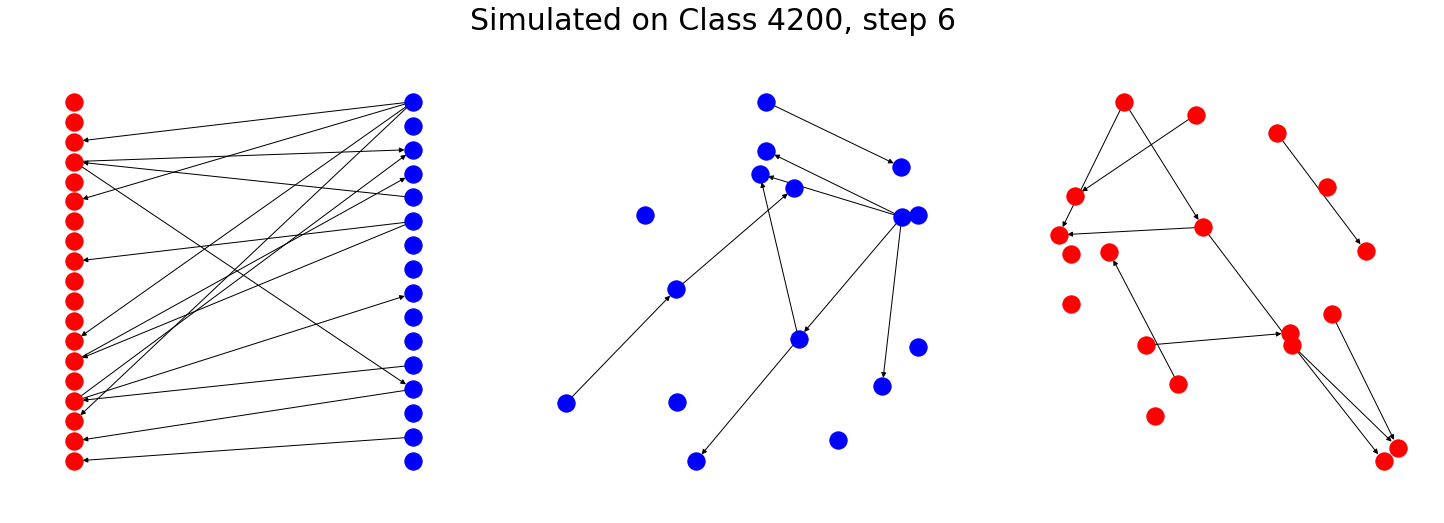

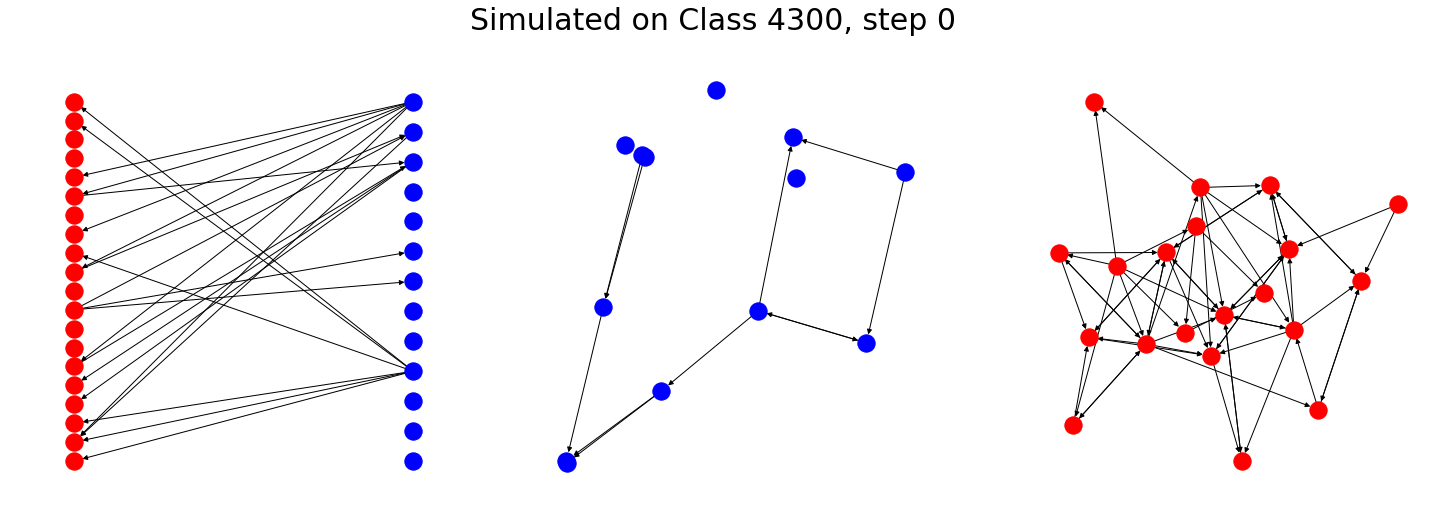

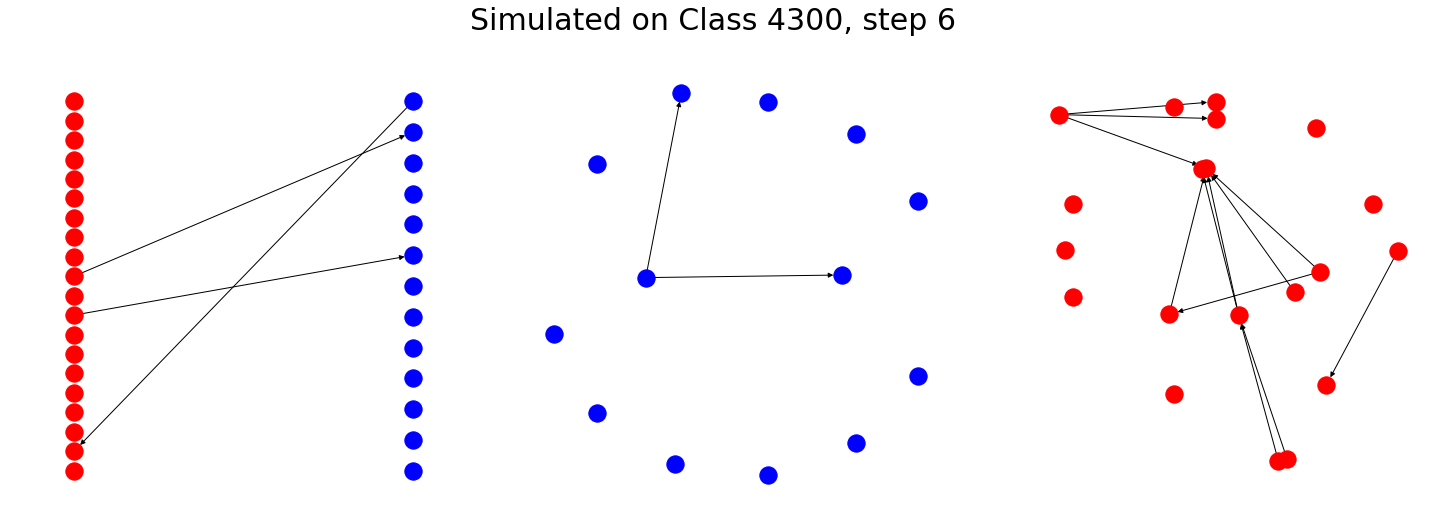

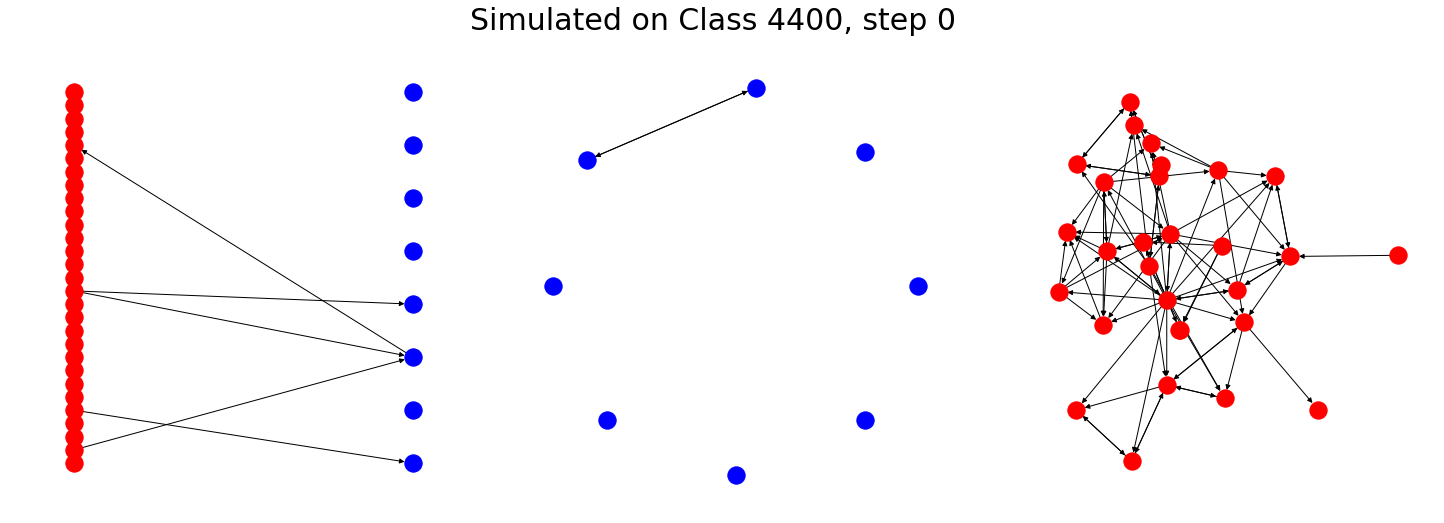

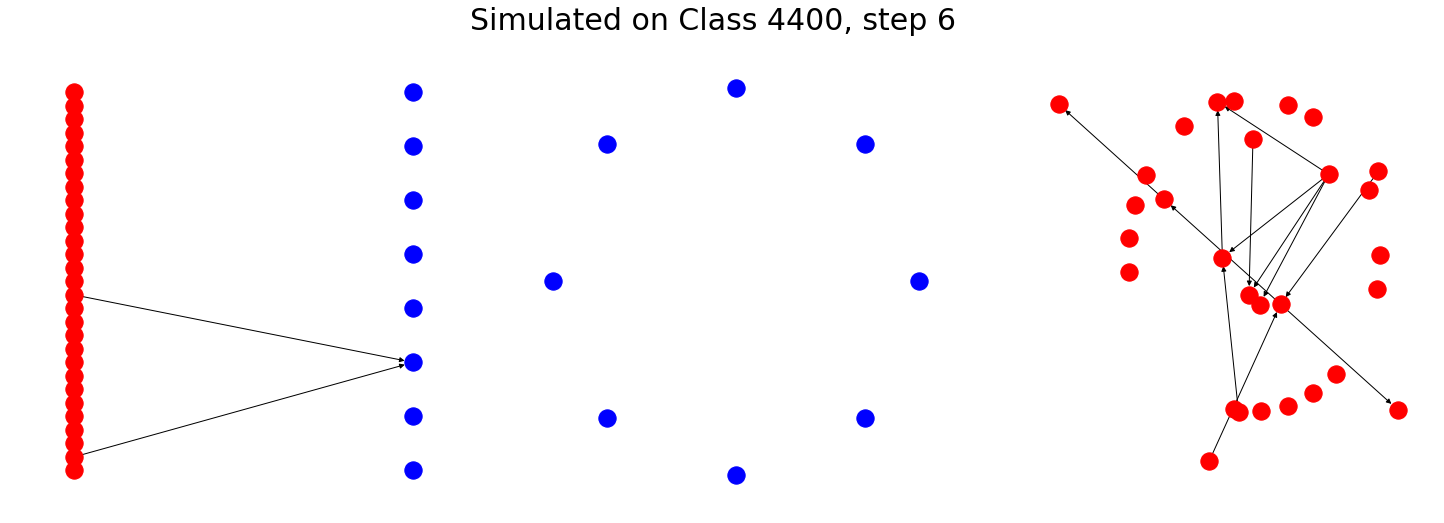

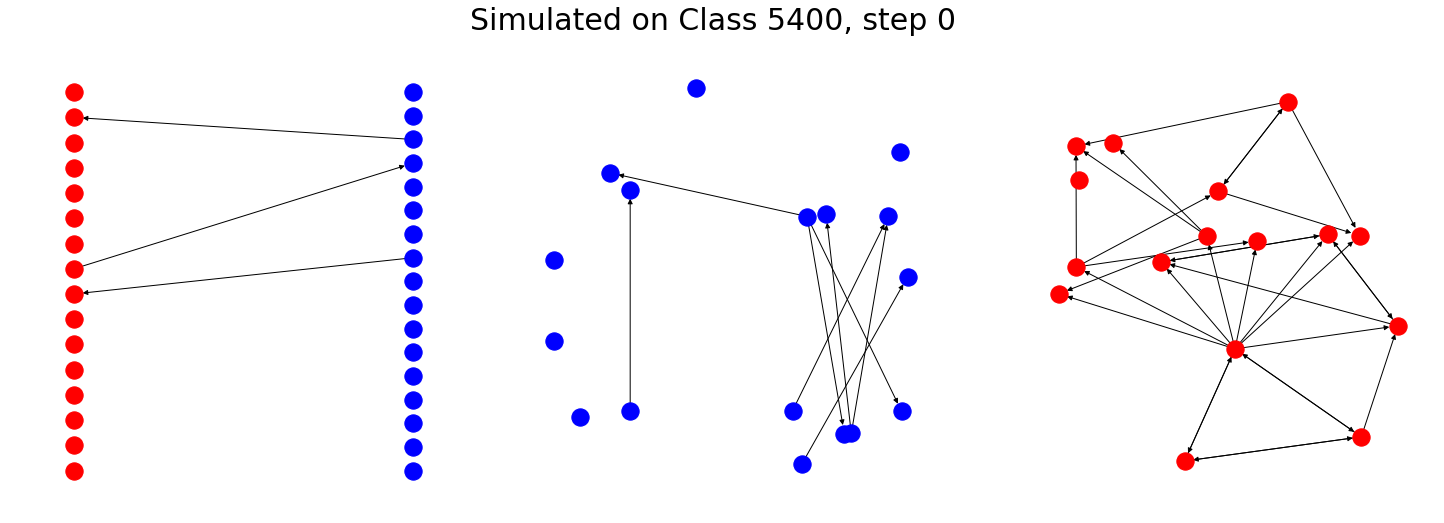

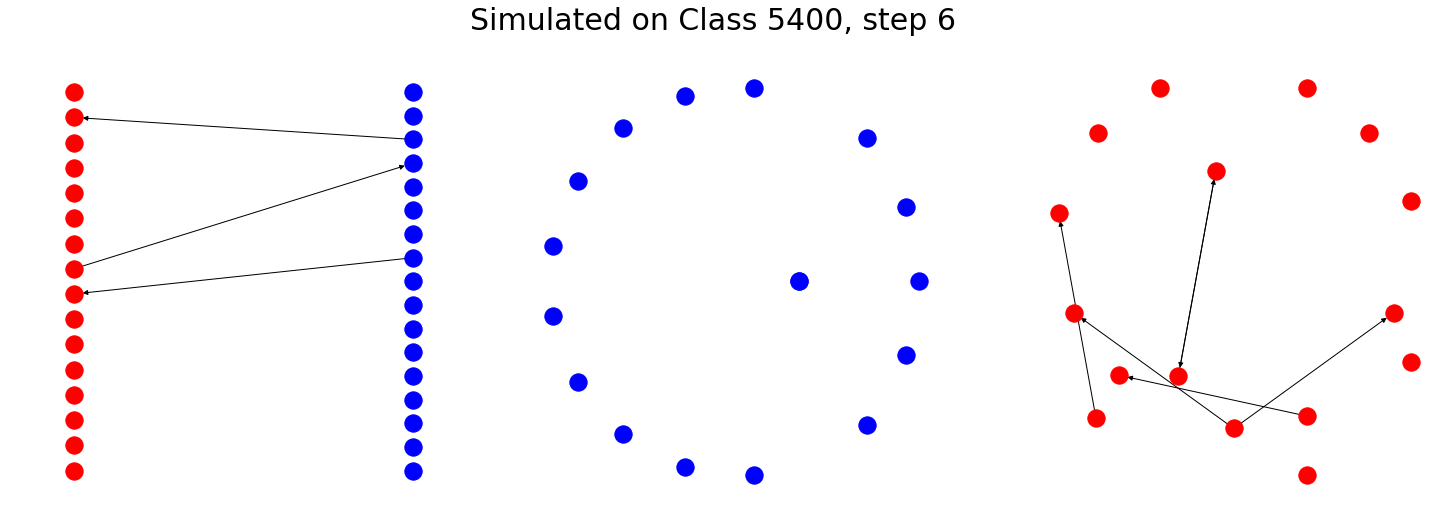

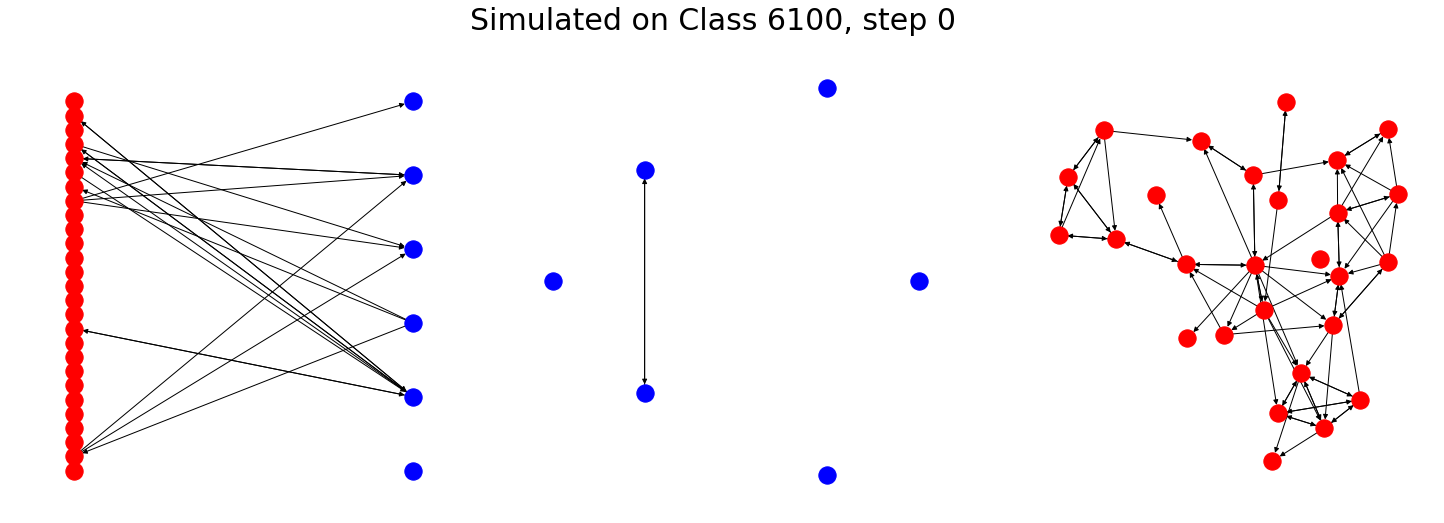

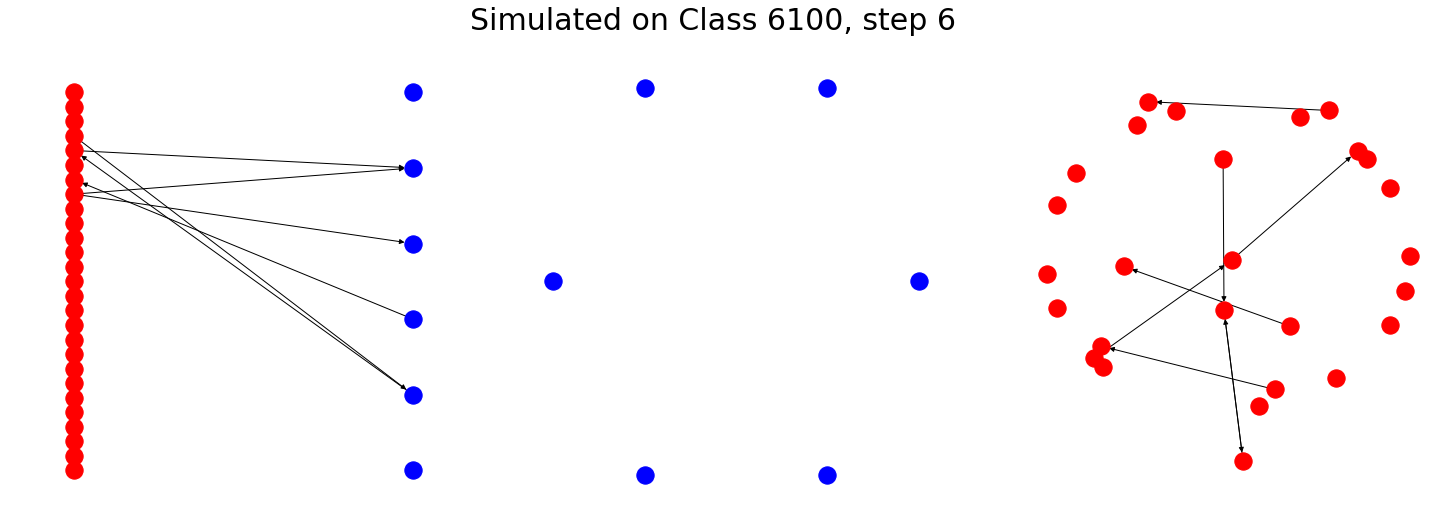

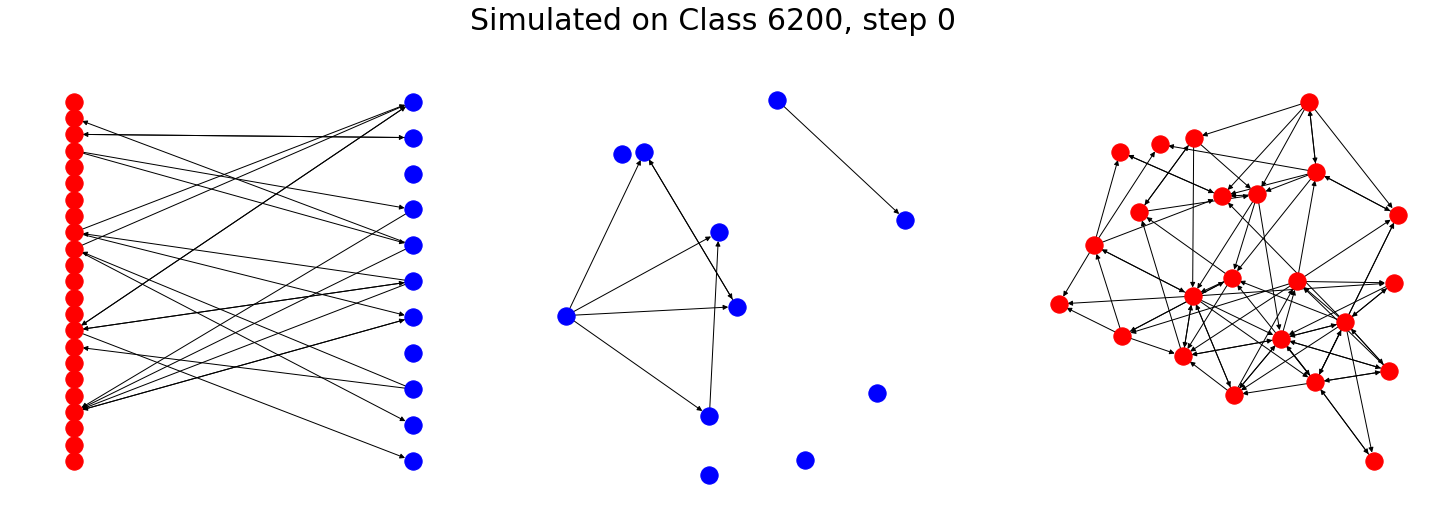

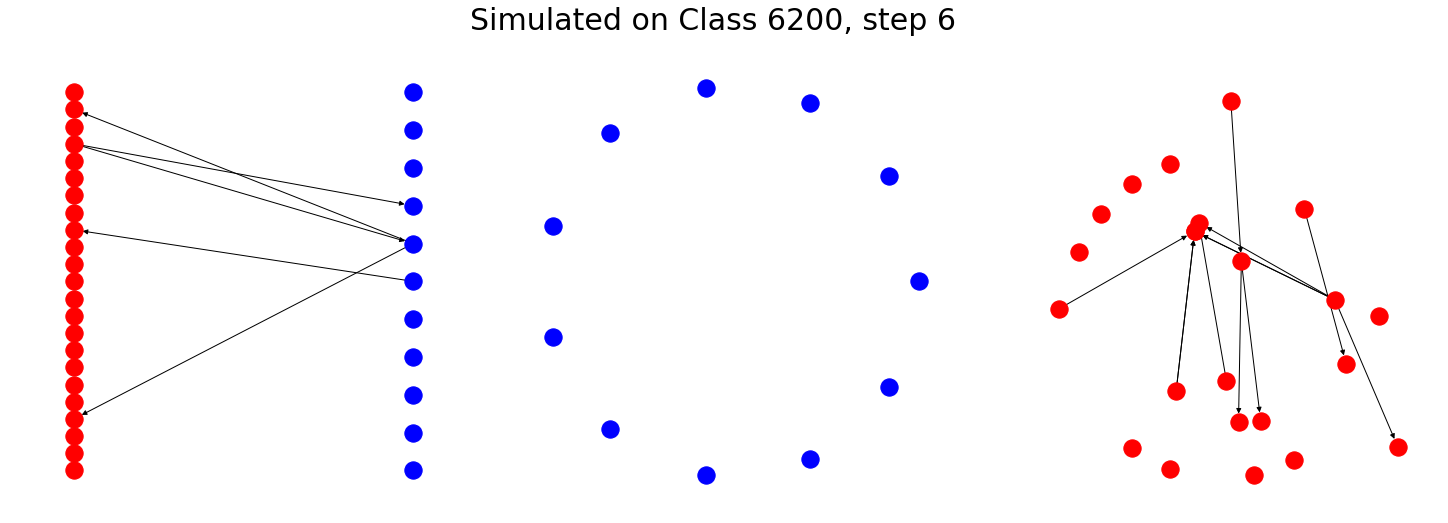

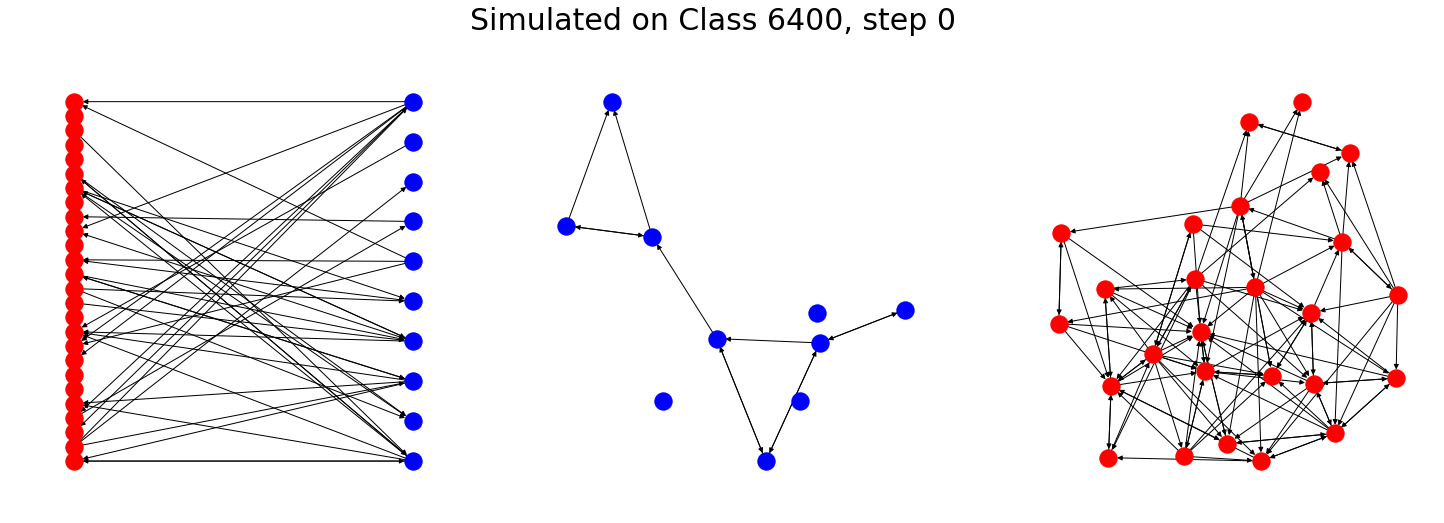

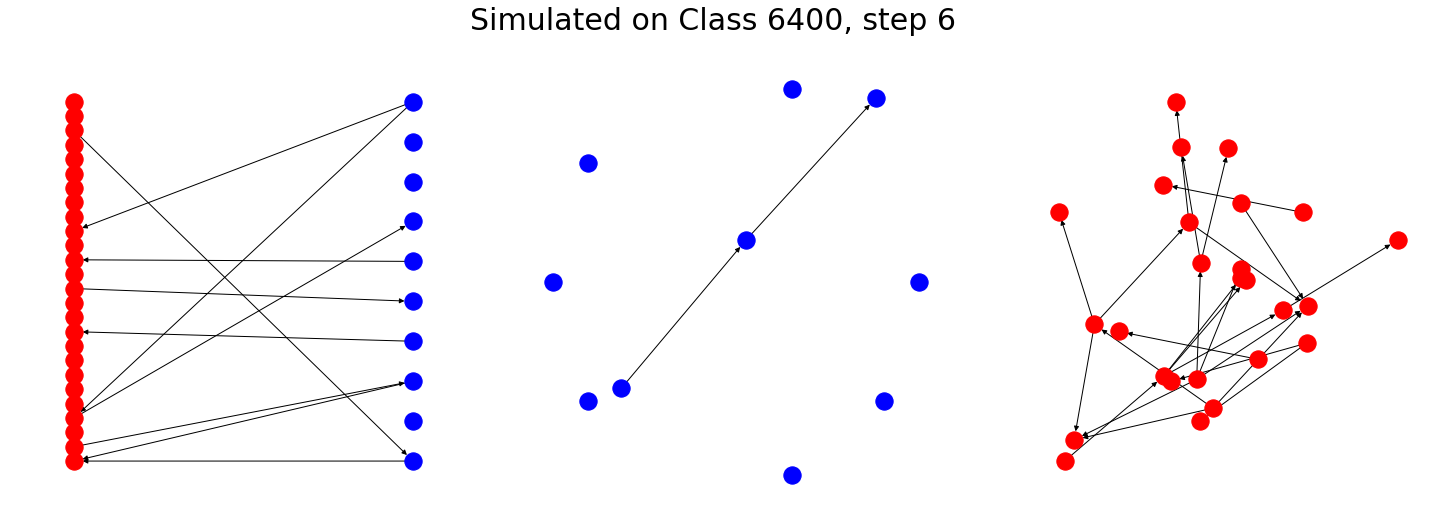

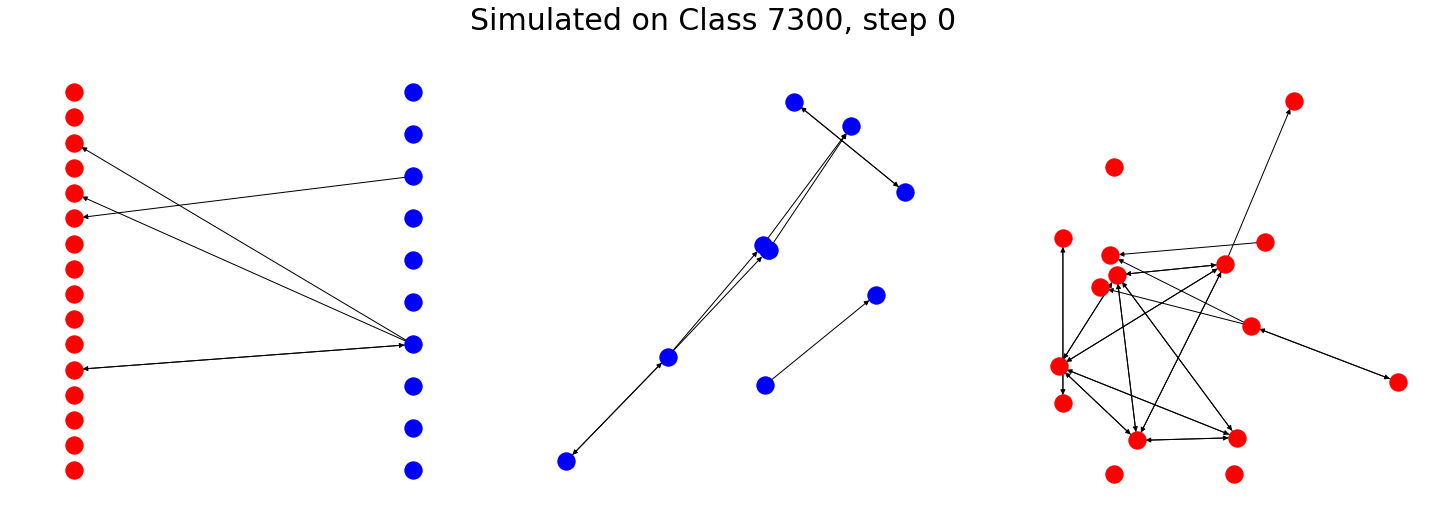

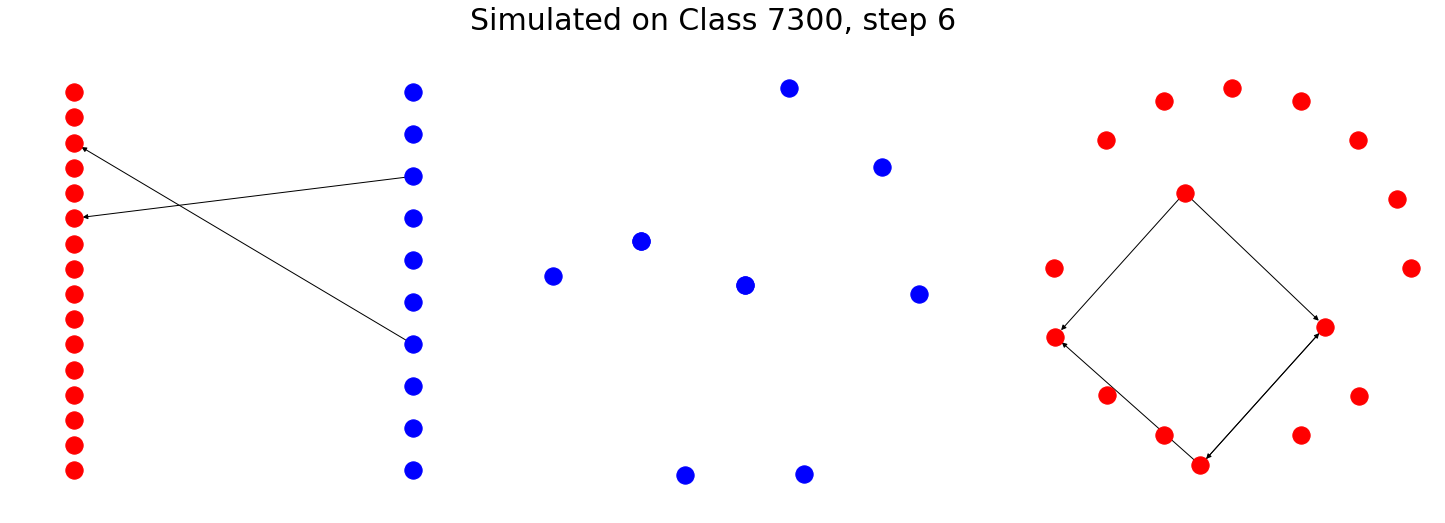

In [18]:
# Visualize all classes in step 0 and step #NUM_STEP
for class_id in class_ids:
    visualize(simulated_networks[class_id][0], class_id, 0)
    visualize(simulated_networks[class_id][NUM_STEP], class_id, NUM_STEP)

In [19]:
def plot_assortativity(networks):
    """
    Draw scatter plots of assortativity of step 0 and step 6
    """
    x_f2f = []
    x_m2m = []
    x_f2m = []
    x_m2f = []
    y_f2f = []
    y_m2m = [] 
    y_f2m = []
    y_m2f = []
    for class_id in class_ids:
        f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][0])
        x_f2f.append(f2f)
        x_m2m.append(m2m)
        x_f2m.append(f2m)
        x_m2f.append(m2f)
        f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][-1])
        y_f2f.append(f2f)
        y_m2m.append(m2m)
        y_f2m.append(f2m)
        y_m2f.append(m2f)
    
    params = ['f2f', 'm2m', 'f2m', 'm2f']
    
    for param in params:
        x = eval('x_{}'.format(param))
        y = eval('y_{}'.format(param))
        
        xymax = max(max(x), max(y)) + 0.05
        plt.xlim((-0.05, xymax))
        plt.ylim((-0.05, xymax))
        plt.suptitle('assortativity {}'.format(param), fontsize = 20)
        plt.scatter(x, y)
        plt.xlabel('Step 0')
        plt.ylabel('Step 6')
        
        # Calculate Pearson Correlation Coefficient
        corr = np.corrcoef(np.vstack([np.array(x), np.array(y)]))
        corr = round(corr[0][1], 2)
        
        # Linear Regression
        coef, error, _, _, _ = np.polyfit(x, y, 1, full = True)
        error = round(error[0], 2)
        plt.plot([-0.05, xymax], np.array([-0.05, xymax]) * coef[0] + coef[1], color='r')
        
        # Hard coding here, sad
        if param == 'f2f':
            plt.text(0.4, 0.4 * coef[0] + coef[1] - 0.2, \
            'slope = {} \n error = {} \n corr = {}'.format(round(coef[0], 2), error, corr))
        else:
            plt.text(xymax/2 + 0.02, xymax/2 * coef[0] + coef[1] - 0.12, \
            'slope = {} \n error = {} \n corr = {}'.format(round(coef[0], 2), error, corr))
        
        
        plt.savefig('assortativity {}.png'.format(param), dpi = 300)
        plt.show()

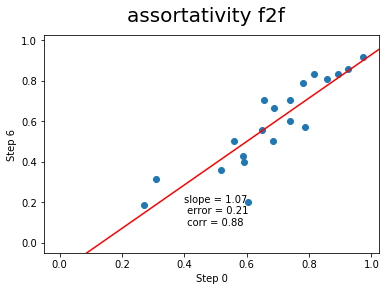

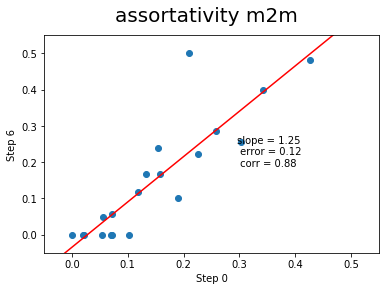

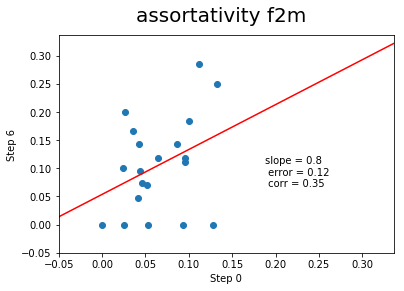

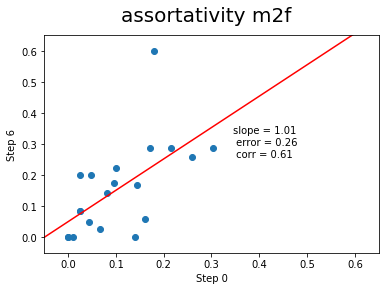

In [20]:
plot_assortativity(simulated_networks)